## MULTI DAPI VAE in PYRO

### IMPORT NECESSARY MODULES

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install moviepy
#! conda update -y pytorch torchvision -c pytorch
#! pip install pyro-ppl --upgrade
# pip install --upgrade Pillow
#!pip install seaborn

In [3]:
import os
import sys
import glob
import moviepy.editor as mpy
import numpy as np
import PIL.Image

#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #for debugging, it decrease performance dramatically

In [4]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML, Image
from mpl_toolkits.mplot3d import Axes3D

In [5]:
from MODULES.utilities import *
from MODULES.vae_model import *

import torch
import pyro
#from pyro.infer import SVI, Trace_ELBO #,TraceEnum_ELBO, TraceGraph_ELBO, config_enumerate, JitTraceEnum_ELBO 

# Set up pyro environment
pyro.clear_param_store()
pyro.set_rng_seed(0)

# Check versions
print("pyro.__version__  --> ",pyro.__version__)
print("torch.__version__ --> ",torch.__version__)

pyro.__version__  -->  1.3.0
torch.__version__ -->  1.5.0


In [6]:
#assert(pyro.__version__.startswith('1.3'))
#assert(torch.__version__.startswith('1.4'))

# We expect to find the file "parameters.json" in the execution directory¶

In [8]:
params = load_json_as_dict("parameters.json")
print(params)

{'wdl.alias': 'disk_shading_yes_bg', 'wdl.memo': 'geco, inactive kl_logit', 'wdl.file_train': 'gs://ld-data-bucket/Allen_smFISH/smFISH_stitched_OLEH.tif', 'wdl.file_test': 'gs://ld-results-bucket/ckpt/dummy.pkl', 'wdl.file_ckpt': 'gs://ld-results-bucket/ckpt/dummy.pkl', 'wdl.bucket_output': 'gs://ld-results-bucket', 'wdl.dir_output': 'merfish_adam', 'wdl.notebook_name': 'MAIN.ipynb', 'wdl.git_repo': 'https://github.com/spacetx/spacetx-research.git', 'wdl.commit_or_branch': 'master', 'simulation': {'__comment': 'there are 3 types of runs: scratch, resume, pre_trained', 'type': 'scratch', 'MAX_EPOCHS': 30001, 'TEST_FREQUENCY': 5, 'CHECKPOINT_FREQUENCY': 20, 'batch_size': 128}, 'architecture': {'__comment': 'architecture parameters, level_zwhere_output is between 0 and n_max_pool included', 'dim_zwhat': 10, 'dim_zmask': 10, 'dim_zwhere': 4, 'dim_logit': 1, 'cropped_size': 28, 'n_max_pool': 4, 'level_zwhere_and_logit_output': 2, 'level_background_output': 4, 'n_ch_output_features': 32, 'n_

# prepare the file names

In [9]:
# CROMWELL will localize: 
# gs://ld-data-bucket/data/fashionmnist_train.pkl -> execution_dir/ld-data-bucket/data/fashionmnist_train.pkl
# Therefore I just need to remove  "gs://"
# Note that every path is relative to the execution_dir

train_file = os.path.basename(params["wdl.file_train"])
test_file = os.path.basename(params["wdl.file_test"])
ckpt_file = os.path.basename(params["wdl.file_ckpt"])
dir_output = params["wdl.dir_output"]

# create output directionry if it does nto exists
try:
    os.mkdir(dir_output)
except FileExistsError:
    pass

# Save input_json_file to output dir
json_param_file = os.path.join(dir_output, "parameters.json")
save_dict_as_json(params,json_param_file)

# checks
assert os.path.isfile(train_file)
assert os.path.isfile(test_file)
assert os.path.isfile(ckpt_file)
    
print(train_file)
print(test_file)
print(dir_output)
print(json_param_file)
print(ckpt_file)

smFISH_stitched_OLEH.tif
dummy.pkl
merfish_adam
merfish_adam/parameters.json
dummy.pkl


# SYNTHETIC DATA

In [11]:
#print("get the data")
#train_file="multi_disk_train_shading_bg_v3.pkl"
#test_file="multi_disk_test_shading_bg_v3.pkl"
#multi_mnist_test_no_bg.pkl

#train_file="multi_mnist_train_simple_v3.pkl"
#test_file="multi_mnist_test_simple_v3.pkl"

##train_file="multi_disk_train_shading_bg.pkl"
##test_file="multi_disk_test_shading_bg.pkl"

#x_train, y_train = load_obj(train_file)
#train_loader = LoaderInMemory(x=x_train, 
#                              y=y_train, 
#                              pin_in_cuda_memory=torch.cuda.is_available(),
#                              batch_size=params["simulation"]["batch_size"],  
#                              shuffle=True)
#                               
#x_test, y_test = load_obj(train_file)
#test_loader = LoaderInMemory(x=x_test, 
#                             y=y_test, 
#                             pin_in_cuda_memory=torch.cuda.is_available(),
#                             batch_size=params["simulation"]["batch_size"],  
#                             shuffle=False)

# REAL DATASETS: Import image and preproces

In [10]:
import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = None
from MODULES.preprocessing import img_pre_processing

pilfile = PIL.Image.open(train_file)
preprocess = img_pre_processing(pilfile, reduction_factor=8, remove_background=True)

In [11]:
adaptive = skimage.exposure.equalize_adapthist(preprocess.img, kernel_size=80, clip_limit=0.03)
gamma = skimage.exposure.adjust_gamma(preprocess.img, gamma=0.5, gain=1)

tensor([2172]) tensor([463])


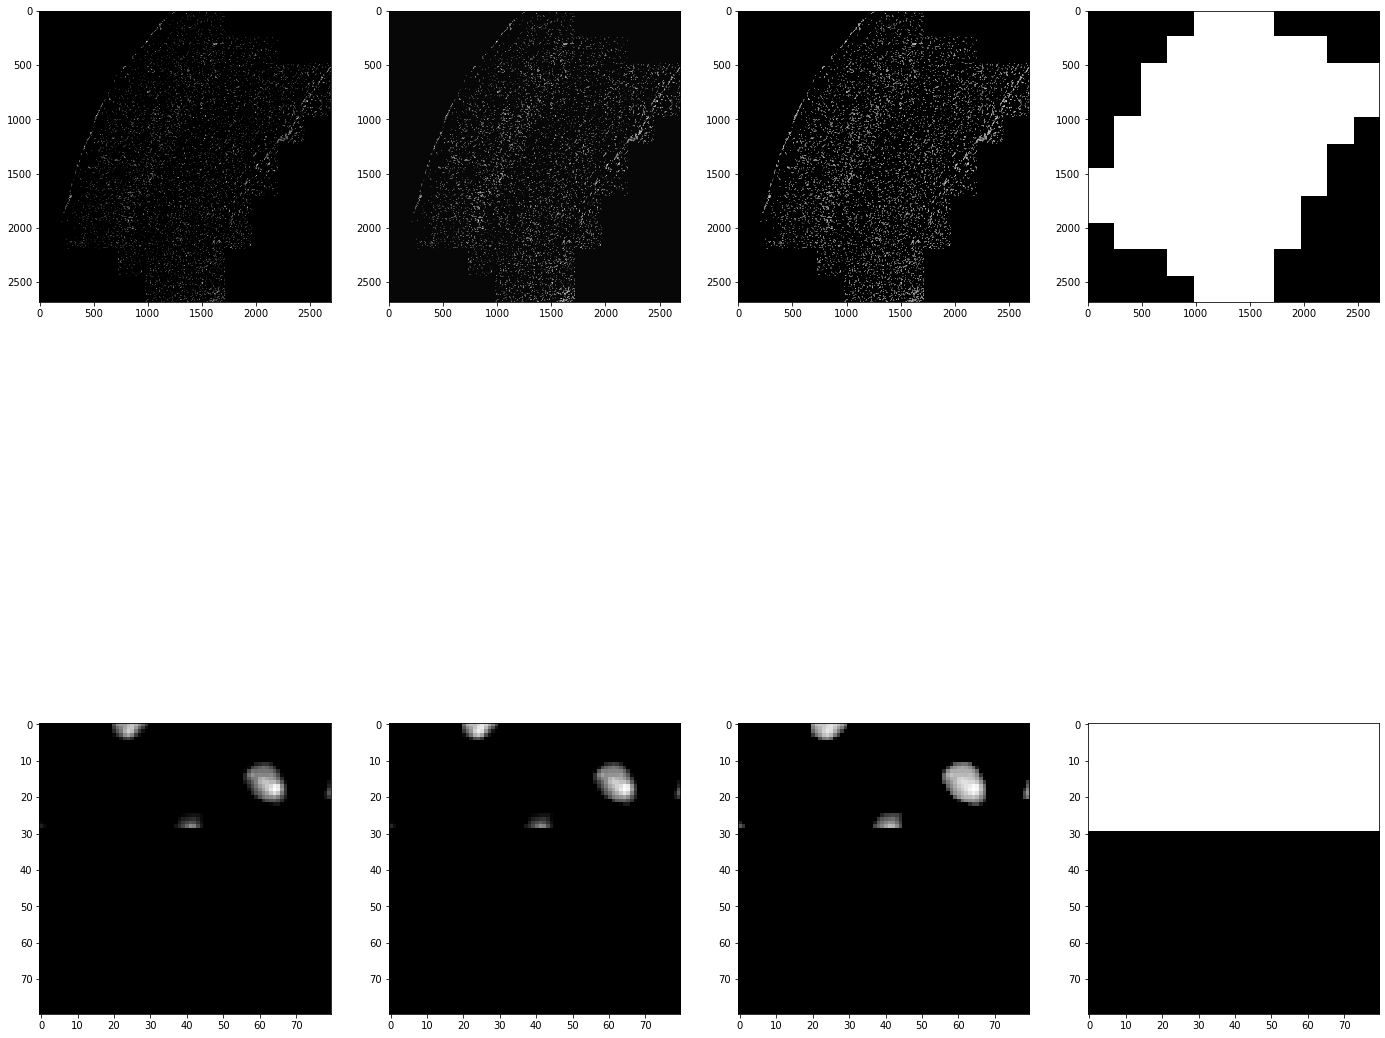

In [12]:
delta = 80
iw = torch.randint(low=0, high=preprocess.img.shape[-2]-delta, size=[1])
ih = torch.randint(low=0, high=preprocess.img.shape[-1]-delta, size=[1])
print(iw,ih)
#iw,ih = 250, 1521

figure, axes = plt.subplots(ncols=4, nrows=2, figsize=(24, 24))
axes[0,0].imshow(preprocess.img, cmap='gray')
axes[0,1].imshow(adaptive, cmap='gray')
axes[0,2].imshow(gamma, cmap='gray')
axes[0,3].imshow(preprocess.mask, cmap='gray')

axes[1,0].imshow(preprocess.img[iw:iw+delta, ih:ih+delta], cmap='gray')
axes[1,1].imshow(adaptive[iw:iw+delta, ih:ih+delta], cmap='gray')
axes[1,2].imshow(gamma[iw:iw+delta, ih:ih+delta], cmap='gray')
axes[1,3].imshow(preprocess.mask[iw:iw+delta, ih:ih+delta], cmap='gray')

### Conversion to torch

In [13]:
img_torch = torch.from_numpy(adaptive).float()[None,None]
mask_torch = torch.from_numpy(preprocess.mask)[None,None]

In [14]:
BATCH_SIZE = params["simulation"]["batch_size"]
random_crops_test = ManyRandomCropsTensor(desired_w=80, desired_h=80, n_crops=2000, mask=mask_torch)
random_crops_train = ManyRandomCropsTensor(desired_w=80, desired_h=80, n_crops=BATCH_SIZE, mask=mask_torch)

train_loader = LoaderInMemory(x=img_torch, 
                              y=None, 
                              data_augmentation=random_crops_train, 
                              transform_y=False, 
                              pin_in_cuda_memory=torch.cuda.is_available(),
                              batch_size=1, 
                              drop_last=False, 
                              shuffle=True)

test_loader = LoaderInMemory(x=random_crops_test(img_torch), 
                              y=None, 
                              data_augmentation=None, 
                              transform_y=False, 
                              pin_in_cuda_memory=torch.cuda.is_available(),
                              batch_size=BATCH_SIZE, 
                              drop_last=False, 
                              shuffle=False)

Dataset lenght: 1
imgs.shape torch.Size([1, 1, 2688, 2688])
type(imgs) <class 'torch.Tensor'>
imgs.device cuda:0
torch.max(imgs) tensor(1., device='cuda:0')
torch.min(imgs) tensor(0., device='cuda:0')
x,y,index shapes -> torch.Size([128, 1, 80, 80]) torch.Size([128]) torch.Size([128])


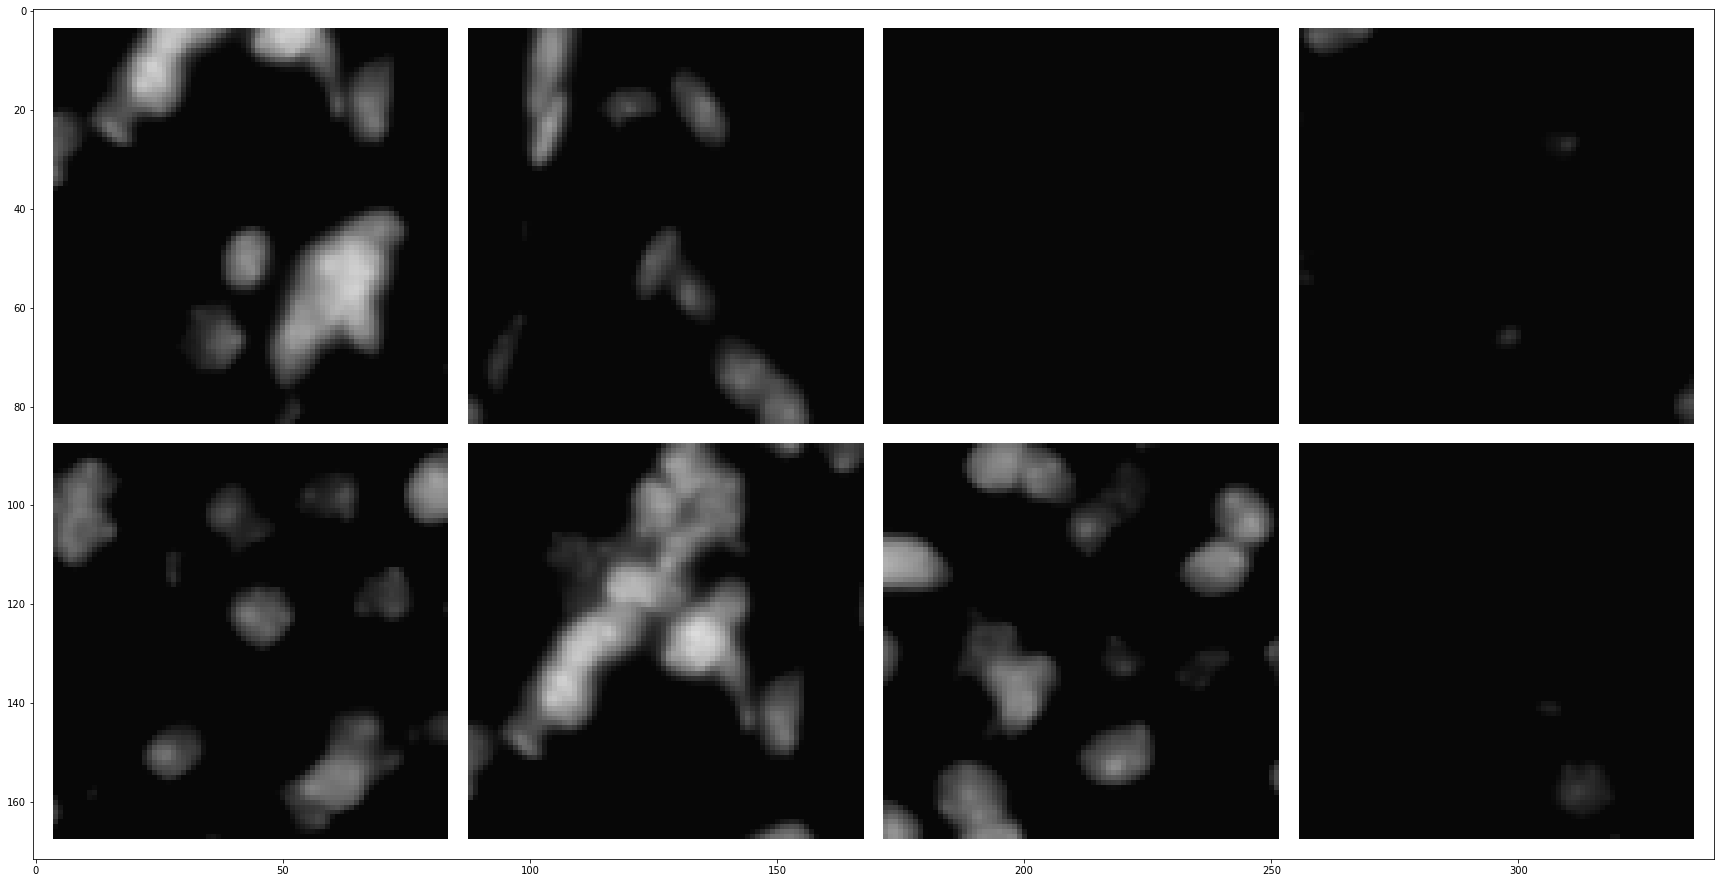

In [15]:
train_loader.check_batch()

Dataset lenght: 2000
imgs.shape torch.Size([2000, 1, 80, 80])
type(imgs) <class 'torch.Tensor'>
imgs.device cuda:0
torch.max(imgs) tensor(1., device='cuda:0')
torch.min(imgs) tensor(0.0299, device='cuda:0')
x,y,index shapes -> torch.Size([128, 1, 80, 80]) torch.Size([128]) torch.Size([128])


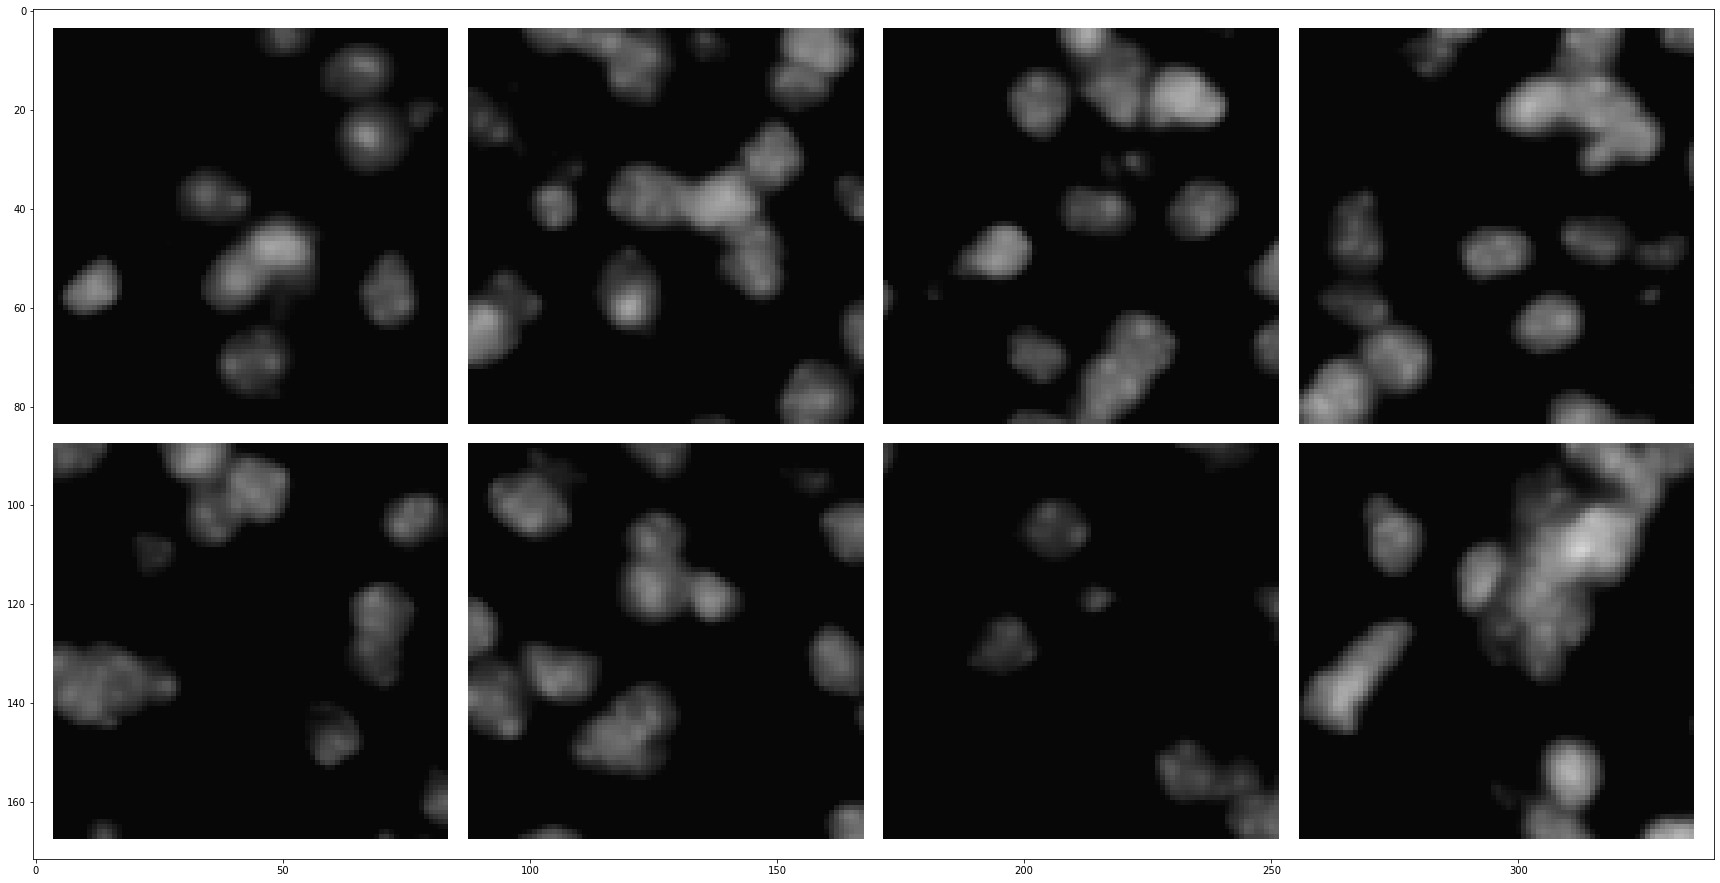

In [16]:
test_loader.check_batch()

### Check the value for fg_fraction 

0.181640625


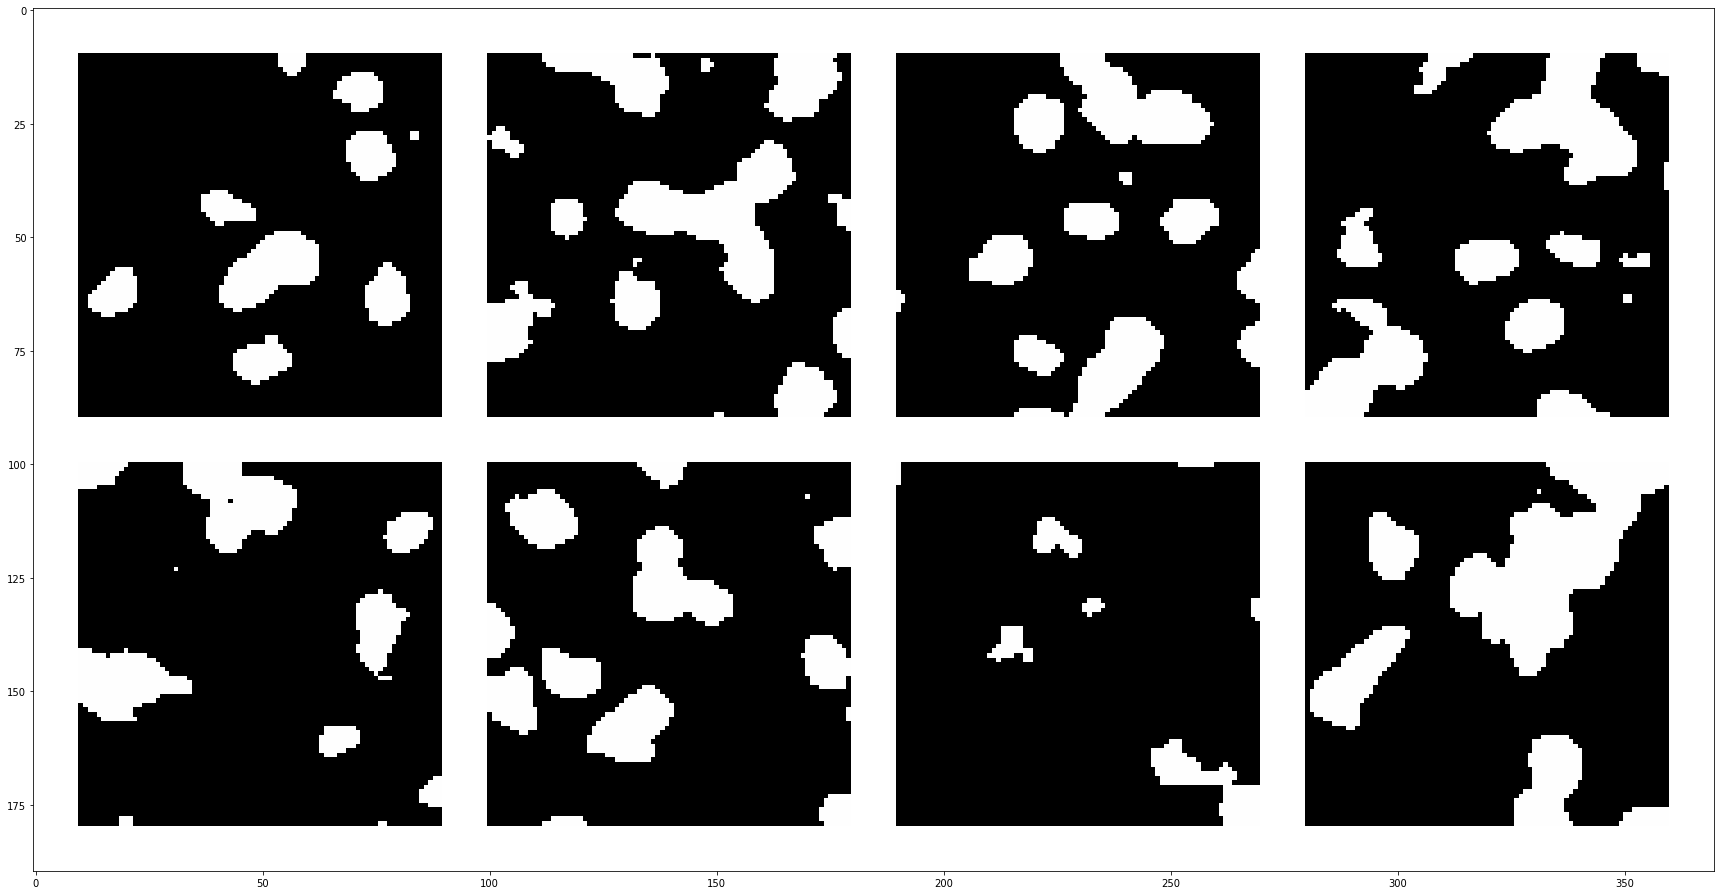

In [17]:
threshold = skimage.filters.threshold_otsu(adaptive)
print(threshold)
binarized_test_dataset = (test_loader.x > threshold).float()
show_batch(binarized_test_dataset[:8], figsize=(24,24))

In [18]:
fg_pixel_fraction = binarized_test_dataset.mean(dim=(-1,-2,-3))
print(fg_pixel_fraction.shape)

torch.Size([2000])


tensor(0.1090, device='cuda:0')


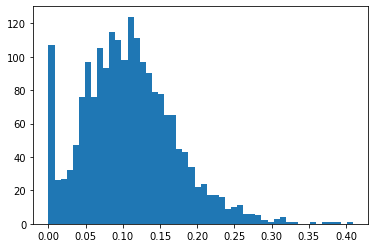

In [19]:
print(fg_pixel_fraction.mean())
_ = plt.hist(fg_pixel_fraction.cpu(), bins=50)


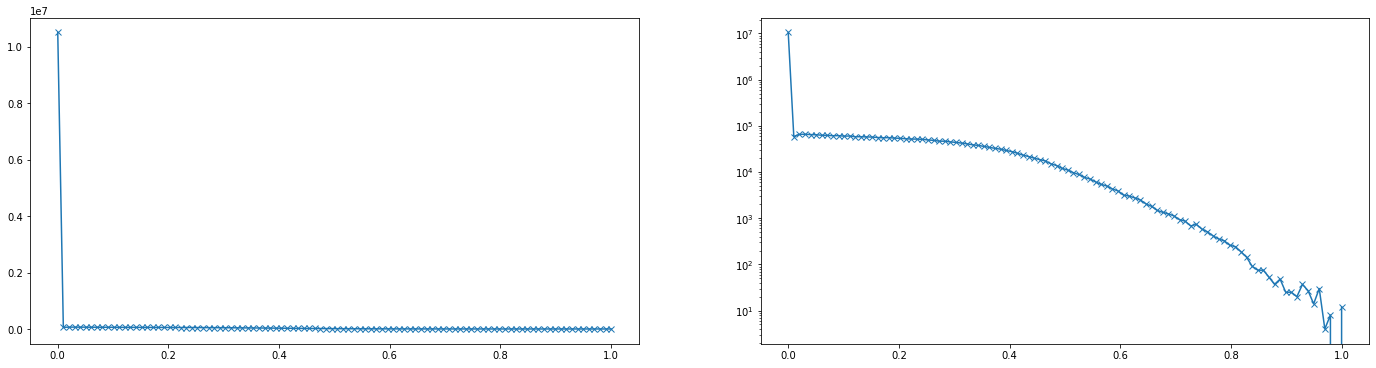

In [20]:
index = torch.linspace(0,1,100)
count = torch.histc(test_loader.x, bins=100)

figure, axes = plt.subplots(ncols=2, figsize=(24, 6))
axes[0].plot(index,count.cpu(),'x-')
axes[1].set_yscale('log')
axes[1].plot(index,count.cpu(),'x-')

# Instantiate model and optimizer

In [21]:
vae = CompositionalVae(params)
optimizer = instantiate_optimizer(model=vae, dict_params_optimizer=params["optimizer"])
#vae

# Does the untrained generator match the data

torch.Size([128, 1, 80, 80]) torch.Size([128]) torch.Size([128])


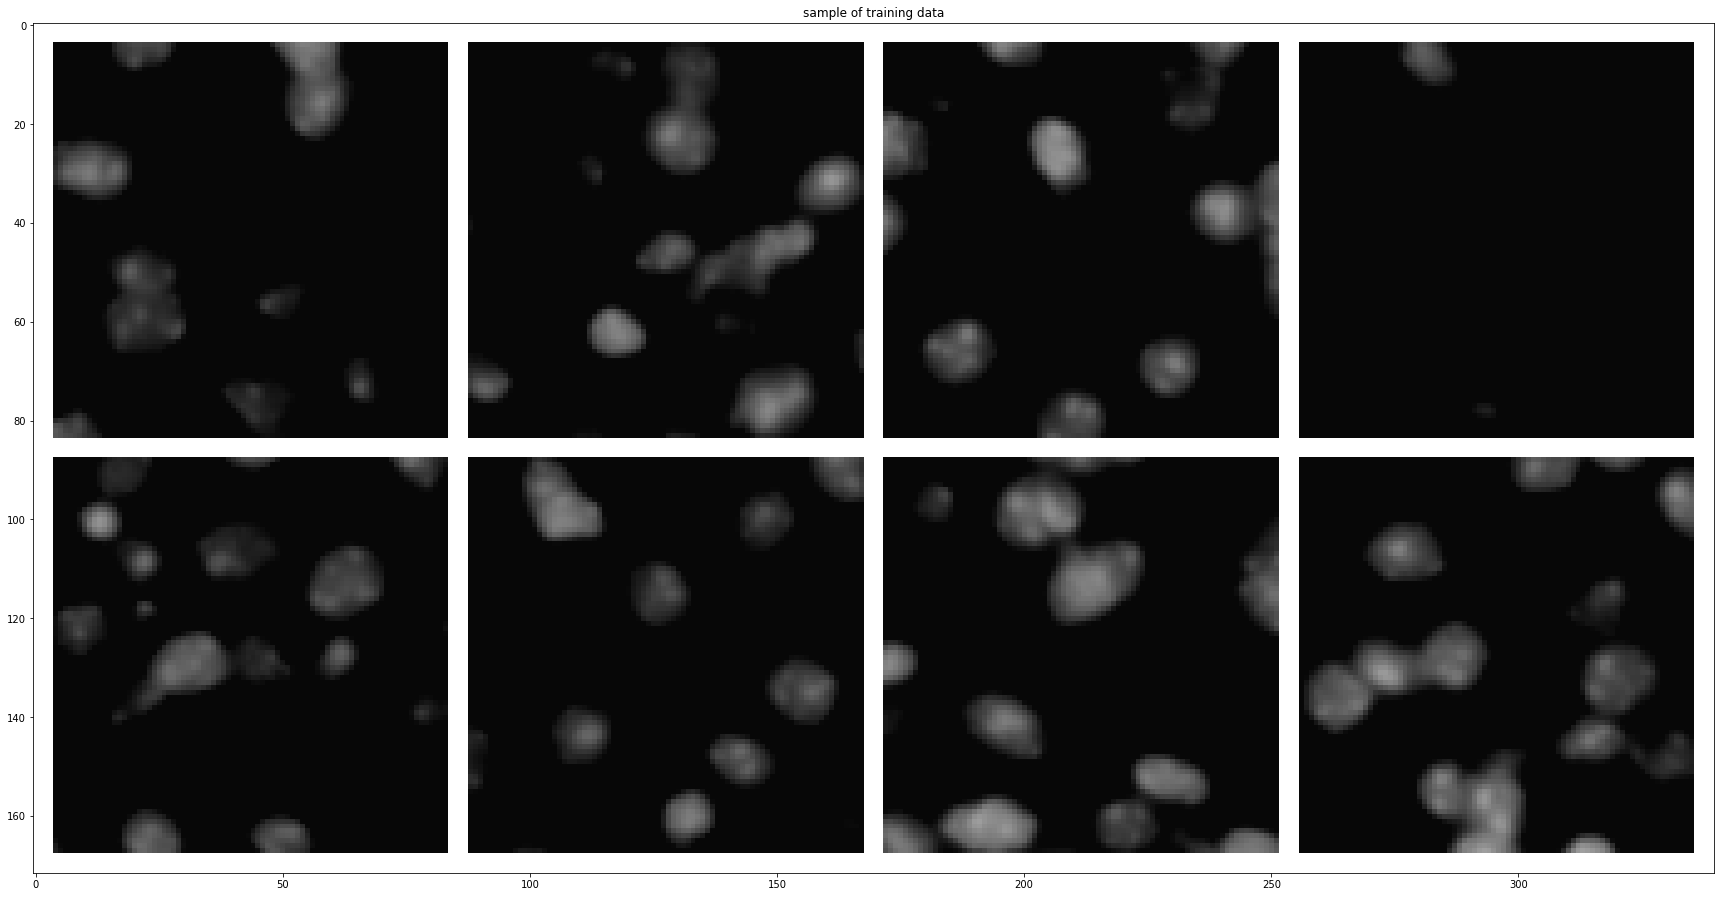

In [22]:
x,y,index = train_loader.load(batch_size=1)
print(x.shape, y.shape, index.shape)
show_batch(x[:8], n_col=4, n_padding=4, pad_value=1, title="sample of training data", figsize=(24,24))

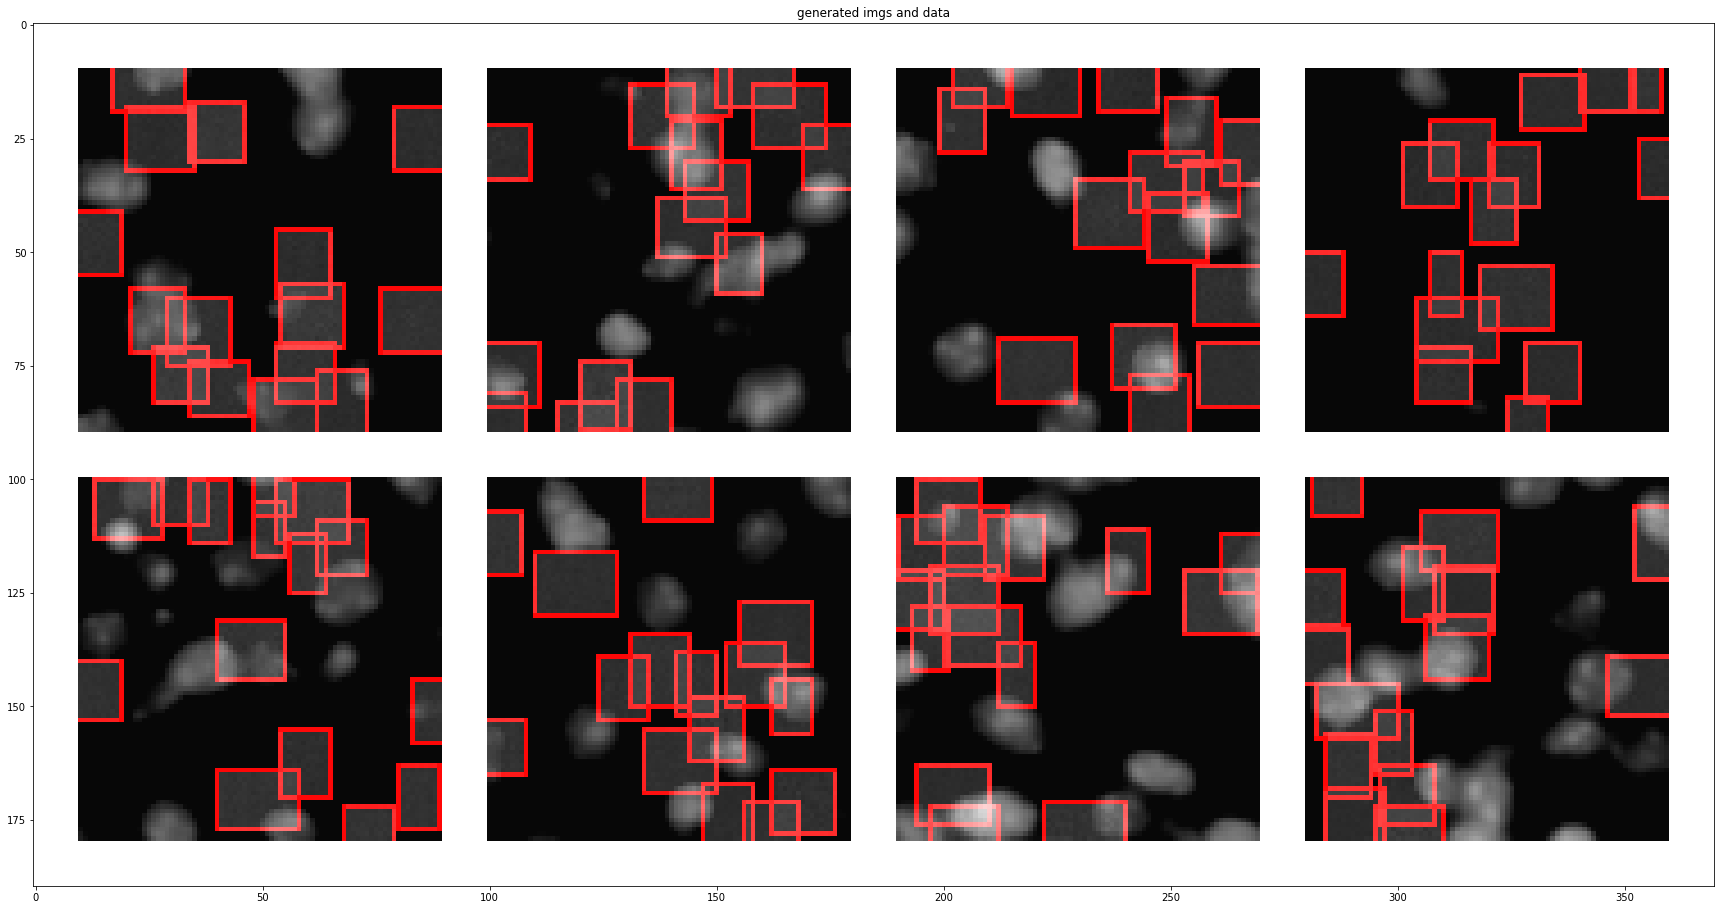

In [23]:
auch = vae.generate(imgs_in=x, draw_bounding_box=True)
show_batch(auch.imgs[:8]+x[:8], title="generated imgs and data", figsize=(24,24))

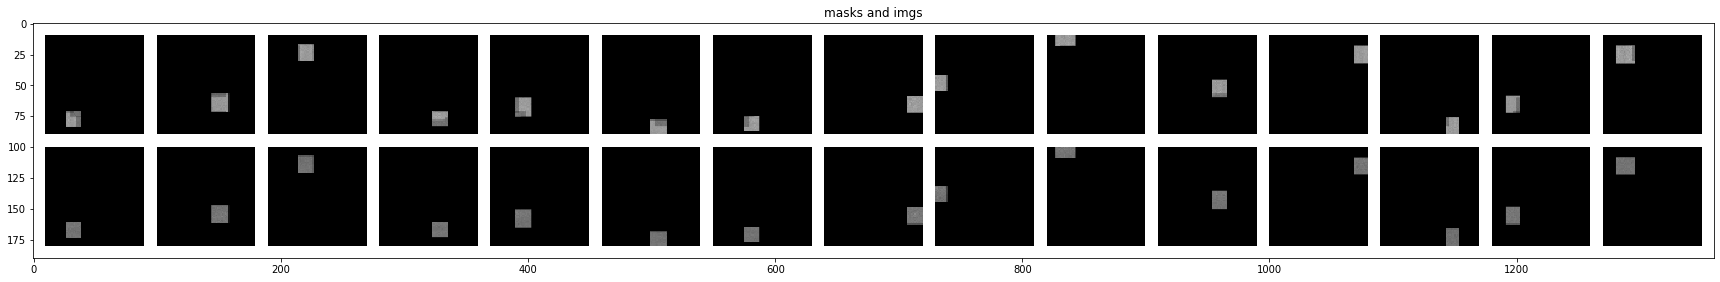

In [24]:
big_mask = auch.inference.big_mask[:,0]
big_img = auch.inference.big_img[:,0]
tmp = torch.cat((big_mask, big_img),dim=0)
show_batch(tmp, n_col=tmp.shape[0]//2, title="masks and imgs", figsize=(24,24))

# Does the segmentation work

torch.Size([8, 1, 80, 80]) torch.Size([8, 3, 80, 80])


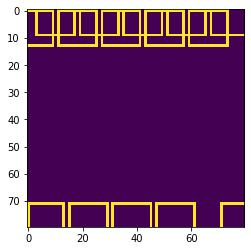

In [25]:
x,y,index = test_loader.load(batch_size=8)
seg_mask = vae.segment(x, draw_bounding_box=True)

print(x.shape,seg_mask.shape)
plt.imshow(seg_mask[0,0].cpu())

In [26]:
#print(train_loader.x.shape)
#seg_mask = vae.segment_with_tiling(train_loader.x, crop_w=80, crop_h=80, stride_w=60, stride_h=60, n_objects_max_per_patch=None, draw_bounding_box=True)

#print(seg_mask.shape)
#plt.imshow(seg_mask[0,0].cpu())

# Check the constraints

In [27]:
vae.dict_soft_constraints

{'__comment': 'all the parameters about the soft constraints',
 'fg_pixel_fraction': {'__comment': 'Fraction of fg_pixel needs to be in a specific range',
  'lower_bound_value': 0.05,
  'lower_bound_width': 0.02,
  'lower_bound_strength': 0.1,
  'lower_bound_exponent': 2,
  'upper_bound_value': 0.25,
  'upper_bound_width': 0.05,
  'upper_bound_strength': 0.1,
  'upper_bound_exponent': 2},
 'overlap': {'__comment': 'cost which discourages masks from overlapping',
  'strength': 0.001,
  'exponent': 1}}

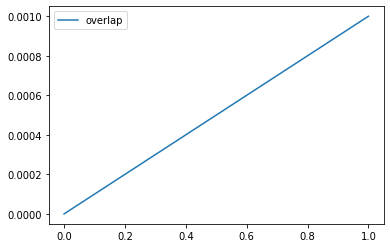

In [28]:
x1=torch.linspace(0,1,100)
y1=sample_from_constraints_dict(dict_soft_constraints=vae.dict_soft_constraints,
                                var_name="overlap", 
                                var_value=x1, 
                                verbose=False)
plt.plot(x1,y1, label="overlap")
plt.legend()

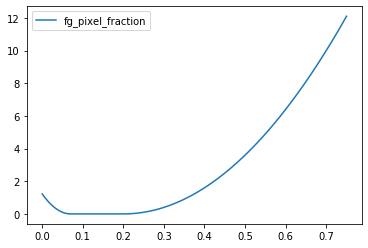

In [29]:
x=torch.linspace(0,0.75,100)
y=sample_from_constraints_dict(dict_soft_constraints=vae.dict_soft_constraints,
                               var_name="fg_pixel_fraction", 
                               var_value=x, 
                               verbose=False)
plt.plot(x, y, label="fg_pixel_fraction")
plt.legend()

# There are 3 possible simulation types: scratch, resumed, pretrained

In [31]:
print("simulation type = "+str(params["simulation"]["type"]))

if (params["simulation"]["type"] == "scratch"):
    
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 99999999

elif (params["simulation"]["type"] == "resumed"):
        
    resumed = load_info(path=ckpt_file, 
                        load_epoch=True, 
                        load_history=True)
    epoch_restart = resumed.epoch
    history_dict = resumed.history_dict
    min_test_loss = min(history_dict["test_loss"])
    
    load_model_optimizer(path=ckpt_file, 
                         model=vae,
                         optimizer=optimizer)

elif (params["simulation"]["type"] == "pretrained"):
       
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 99999999
    
    load_model_optimizer(path=ckpt_file, 
                         model=vae,
                         optimizer=None)
    
# instantiate the scheduler if necessary    
if params["optimizer"]["scheduler_is_active"]:
    scheduler = instantiate_scheduler(optimizer=optimizer, dict_params_scheduler=params["optimizer"])

simulation type = scratch


# Training loop

In [32]:
TEST_FREQUENCY = params["simulation"]["TEST_FREQUENCY"]
CHECKPOINT_FREQUENCY = params["simulation"]["CHECKPOINT_FREQUENCY"]
NUM_EPOCHS = params["simulation"]["MAX_EPOCHS"]

In [33]:
for delta_epoch in range(1,NUM_EPOCHS+1):
    epoch = delta_epoch+epoch_restart    
    
    ## vae.is_geco_selftuning = False
    ## vae.geco_mu_detached = linear_interpolation(epoch, 
    ##                                             values=[0.95,0.5],
    ##                                             times=[100,500])
    
    vae.prob_corr_factor=linear_interpolation(epoch, 
                                              values=params["shortcut_prob_corr_factor"]["values"],
                                              times=params["shortcut_prob_corr_factor"]["times"])
        
    #with torch.autograd.set_detect_anomaly(True):
    with torch.autograd.set_detect_anomaly(False):
        vae.train()
        with torch.enable_grad():
            train_metrics = process_one_epoch(model=vae, 
                                              dataloader=train_loader, 
                                              optimizer=optimizer, 
                                              verbose=(epoch==0), 
                                              weight_clipper=None)
        with torch.no_grad():        
            s = pretty_print_metrics(epoch, train_metrics, is_train=True)
            print(s,"prob_factor=%.4f" %(vae.prob_corr_factor))
            
            history_dict = append_dict_to_dict(source=train_metrics, 
                                               target=history_dict,
                                               prefix_exclude="wrong_examples",
                                               prefix_to_add="train_")
        
    if params["optimizer"]["scheduler_is_active"]:
        scheduler.step(epoch=epoch)
    
    if(epoch % TEST_FREQUENCY == 0):
        vae.eval()
        with torch.no_grad():
            test_metrics = process_one_epoch(model=vae, 
                                             dataloader=test_loader, 
                                             optimizer=optimizer, 
                                             verbose=(epoch==0), 
                                             weight_clipper=None)
        
            s = pretty_print_metrics(epoch, test_metrics, is_train=False)
            print(s,"prob_factor %.4f" %(vae.prob_corr_factor))
        
            history_dict = append_dict_to_dict(source=train_metrics, 
                                               target=history_dict,
                                               prefix_exclude="wrong_examples",
                                               prefix_to_add="test_")
        
            test_loss = test_metrics["loss"]
            min_test_loss = min(min_test_loss, test_loss)
            
            if((test_loss == min_test_loss) or ((epoch % CHECKPOINT_FREQUENCY) == 0)): 
                checkpoint_file = os.path.join(dir_output, "ckp_"+str(epoch)+".pkl")
                history_file = os.path.join(dir_output, "history_"+str(epoch)+".pkl")
            
                save_everything(model=vae, 
                                optimizer=optimizer, 
                                history_dict=history_dict, 
                                epoch=epoch, 
                                hyperparams_dict=params, 
                                path=checkpoint_file)
            
                save_dict_as_json(history_dict, path=history_file)
                print("saved files -> "+checkpoint_file+"  "+history_file)

i =   0 train_loss=58.86205
Train [epoch    0] loss=58.862, nll=52.813, reg=0.013, kl_tot=0.314, sparsity=5.722, acc=0.000, n_obj=5.102, geco_sp=0.999, geco_nll=1.000 prob_factor=0.5000
i =   0 train_loss=54.31872
i =   1 train_loss=51.90962
i =   2 train_loss=54.64332
i =   3 train_loss=53.43839
i =   4 train_loss=52.29689
i =   5 train_loss=54.10026
i =   6 train_loss=53.49246
i =   7 train_loss=54.77768
i =   8 train_loss=52.08827
i =   9 train_loss=52.76294
i =  10 train_loss=53.16034
i =  11 train_loss=53.06938
i =  12 train_loss=53.84740
i =  13 train_loss=55.16320
i =  14 train_loss=51.97004
i =  15 train_loss=51.22515
Test  [epoch    0] loss=53.315, nll=47.458, reg=0.022, kl_tot=0.391, sparsity=5.420, acc=0.000, n_obj=4.624, geco_sp=0.999, geco_nll=1.001 prob_factor 0.5000
saved files -> merfish_adam/ckp_0.pkl  merfish_adam/history_0.pkl
Train [epoch    1] loss=51.925, nll=46.135, reg=0.011, kl_tot=0.387, sparsity=5.368, acc=0.000, n_obj=5.727, geco_sp=0.998, geco_nll=1.001 pro

KeyboardInterrupt: 

# Test generator after training

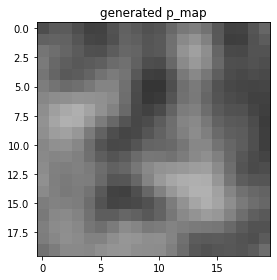

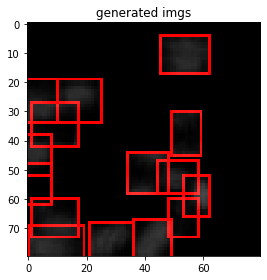

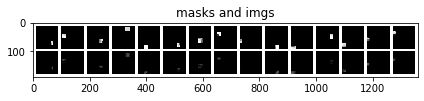

In [34]:
imgs_in_tmp, labels, index = train_loader.load(batch_size=8)
auch = vae.generate(imgs_in=imgs_in_tmp[:1], draw_bounding_box=True)

pmap_gen = show_batch(auch.inference.p_map[:8], title="generated p_map")
imgs_gen = show_batch(auch.imgs[:8], title="generated imgs")
display(pmap_gen, imgs_gen)

big_mask = auch.inference.big_mask[:,0]
big_img = auch.inference.big_img[:,0]
tmp = torch.cat((big_mask, big_img),dim=0)
show_batch(tmp, n_col=tmp.shape[0]//2, title="masks and imgs")

# Check the segmentation results

torch.Size([8, 1, 80, 80]) torch.Size([8, 1, 80, 80])


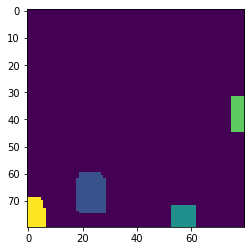

In [35]:
#seg_mask = vae.segment_with_tiling(train_loader.x[...,2000:2400,2000:2400], 
#                                   crop_w=80, crop_h=80, 
#                                   stride_w=60, stride_h=60, n_objects_max_per_patch=10)

x,y,index = test_loader.load(batch_size=8)
seg_mask = vae.segment(x)
print(x.shape, seg_mask.shape)
#show_batch(seg_mask)
plt.imshow(seg_mask[0,0].cpu())
#plt.imshow(x[0,0].cpu())
    
#figure, axes = plt.subplots(ncols=2, figsize=(24, 24))
#axes[1].imshow(train_loader.x[0,0,2000:2400,2000:2400], cmap='gray')
#axes[0].imshow(seg_mask[0,0])

# Check the results

In [36]:
train_metrics

{'loss': 19.391488619036743,
 'nll': 14.588138580322266,
 'reg': 0.027368737384676933,
 'kl_tot': 1.6904470920562744,
 'kl_what': 0.6175795197486877,
 'kl_mask': 0.26099297404289246,
 'kl_where': 0.4445810914039612,
 'kl_logit': 7251.7587890625,
 'sparsity': 2.4684715270996094,
 'n_obj': 8.8203125,
 'geco_sparsity': 0.9939957800408087,
 'geco_nll': 1.043233791435301,
 'delta_1': 0.0,
 'delta_2': -13.588138580322266,
 'cost_fg_pixel_fraction': 0.01669786125421524,
 'cost_overlap': 0.010670876130461693,
 'accuracy': 0.0,
 'wrong_examples': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [37]:
for k,v in history_dict.items():
    if k.startswith("train"):
        print(k," -->", history_dict[k][-3:])

train_loss  --> [18.714006901479273, 17.7213870498327, 19.391488619036743]
train_nll  --> [13.953022003173828, 13.04336929321289, 14.588138580322266]
train_reg  --> [0.03765453025698662, 0.03271320462226868, 0.027368737384676933]
train_kl_tot  --> [1.6423133611679077, 1.5831691026687622, 1.6904470920562744]
train_kl_what  --> [0.5578345060348511, 0.5586527585983276, 0.6175795197486877]
train_kl_mask  --> [0.3660208582878113, 0.2804248034954071, 0.26099297404289246]
train_kl_where  --> [0.4639836847782135, 0.4519268572330475, 0.4445810914039612]
train_kl_logit  --> [6762.154296875, 7038.7900390625, 7251.7587890625]
train_sparsity  --> [2.501584053039551, 2.516772508621216, 2.4684715270996094]
train_n_obj  --> [8.5859375, 8.5625, 8.8203125]
train_geco_sparsity  --> [0.9939960641151107, 0.9939959150384067, 0.9939957800408087]
train_geco_nll  --> [1.0424891197877821, 1.0428625133939382, 1.043233791435301]
train_delta_1  --> [0.0, 0.0, 0.0]
train_delta_2  --> [-12.953022003173828, -12.04336

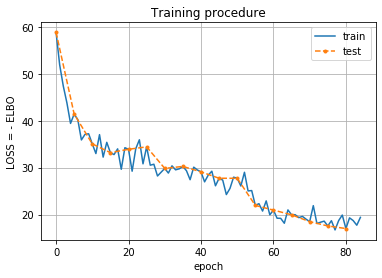

In [38]:
#plt.yscale('log')
y_shift=0
x_shift=0
sign=1
plt.plot(np.arange(x_shift, x_shift+len(history_dict["train_loss"])), 
         sign*np.array(history_dict["train_loss"])+y_shift,'-')
plt.plot(np.arange(x_shift, x_shift+len(history_dict["test_loss"])*TEST_FREQUENCY,TEST_FREQUENCY), 
         sign*np.array(history_dict["test_loss"])+y_shift, '.--')
plt.xlabel('epoch')
plt.ylabel('LOSS = - ELBO')
plt.title('Training procedure')
#plt.ylim(ymax=2)
plt.grid(True)
plt.legend(['train', 'test'])
#plt.show()

fig_file = os.path.join(dir_output, "train.png")
plt.savefig(fig_file)

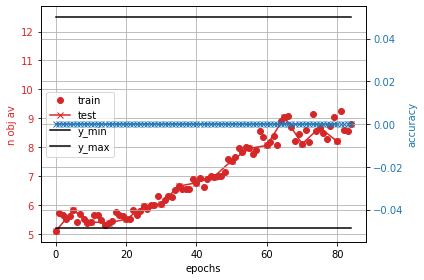

In [39]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('n obj av', color=color)
ax1.plot(np.arange(0, len(history_dict["train_n_obj"])),
         history_dict["train_n_obj"], 'o', color=color, label="train")
ax1.plot(np.arange(0, len(history_dict["test_n_obj"])*TEST_FREQUENCY, TEST_FREQUENCY),
         history_dict["test_n_obj"], 'x-', color=color, label="test")

ymin=min(params["GECO"]["target_n_obj"])
ymax=max(params["GECO"]["target_n_obj"])
ax1.plot(ymin*np.ones(len(history_dict["train_n_obj"])), '-', color='black', label="y_min")
ax1.plot(ymax*np.ones(len(history_dict["train_n_obj"])), '-', color='black', label="y_max")

ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()
#ax1.set_ylim([1000,1870])
plt.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0, len(history_dict["train_accuracy"])),
         history_dict["train_accuracy"],'x', color=color)
ax2.plot(np.arange(0, len(history_dict["test_accuracy"])*TEST_FREQUENCY, TEST_FREQUENCY),
         history_dict["test_accuracy"],'-', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid()
#ax2.set_ylim([0.97,1.0])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig_file = os.path.join(dir_output, "accuracy.png")
plt.savefig(fig_file)

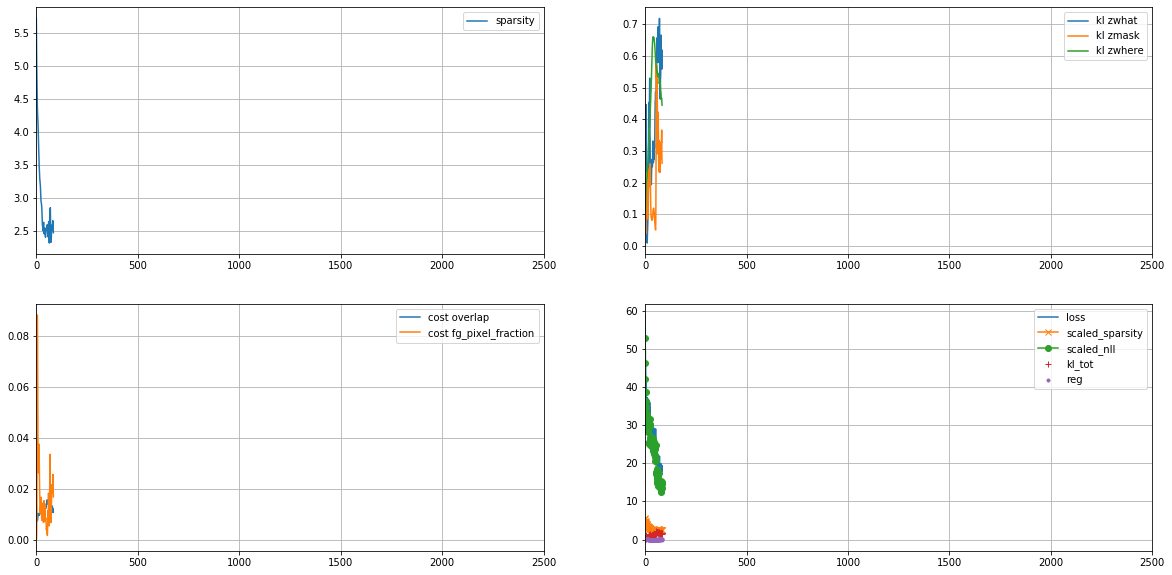

In [40]:
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)
epoch_min, epoch_max = 0, 2500

ax.plot(np.array(history_dict["train_sparsity"]),'-',label='sparsity')
#ax.set_ylim([0,10])
ax.set_xlim([epoch_min, epoch_max])

ax.grid()
ax.legend()

ax2.plot(np.array(history_dict["train_kl_what"]),'-',label='kl zwhat')
ax2.plot(np.array(history_dict["train_kl_mask"]),'-',label='kl zmask')
ax2.plot(np.array(history_dict["train_kl_where"]),'-',label='kl zwhere')
#ax2.plot(np.array(history_dict["train_kl_logit"]),'-',label='kl logit')
#ax2.set_ylim([0,1])
ax2.set_xlim([epoch_min, epoch_max])

ax2.grid()
ax2.legend()

#ax3.plot(history_dict["soft_cost_total_raw"],'-',label='cost total')
ax3.plot(history_dict["train_cost_overlap"],'-',label='cost overlap')
ax3.plot(history_dict["train_cost_fg_pixel_fraction"],'-',label='cost fg_pixel_fraction')
#ax3.plot(history_dict["train_cost_volume_mask_fraction"],'-',label='cost volume_mask_fraction')
#ax3.plot(history_dict["train_cost_prob_map_integral"],'-',label='cost prob_map_integral')
#ax3.plot(history_dict["train_cost_prob_map_fraction"],'-',label='cost prob_map_fraction')
#ax3.plot(history_dict["train_cost_prob_map_TV"],'-',label='cost prob_map_TV')
#ax3.plot(history_dict["train_reg"],'-',label='all_reg')
#ax3.set_ylim([0,1.1])
ax3.set_xlim([epoch_min, epoch_max])

ax3.grid()
ax3.legend()

ax4.plot(history_dict["train_loss"],'-',label='loss')
ax4.plot(np.array(history_dict["train_geco_sparsity"])*np.array(history_dict["train_sparsity"]),'x-',label='scaled_sparsity')
ax4.plot(np.array(history_dict["train_geco_nll"])*np.array(history_dict["train_nll"]),'o-',label='scaled_nll')
ax4.plot(history_dict["train_kl_tot"],'+',label='kl_tot')
ax4.plot(history_dict["train_reg"],'.',label='reg')
#ax4.set_ylim([0,5])
ax4.set_xlim([epoch_min, epoch_max])
ax4.grid()
ax4.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig_file = os.path.join(dir_output, "metrics.png")
plt.savefig(fig_file)

In [41]:
params["GECO"]

{'__comment': 'if active=false use ELBO, else use GECO with Log-Likelihood threshold = n_pixels * n_channel * threshold',
 'is_active': True,
 'factor_nll_range': [0.0, 1.0, 40.0],
 'factor_sparsity_range': [0.0, 1.0, 40.0],
 'target_n_obj': [5.2, 12.5],
 'target_nll': [0.5, 1.0]}

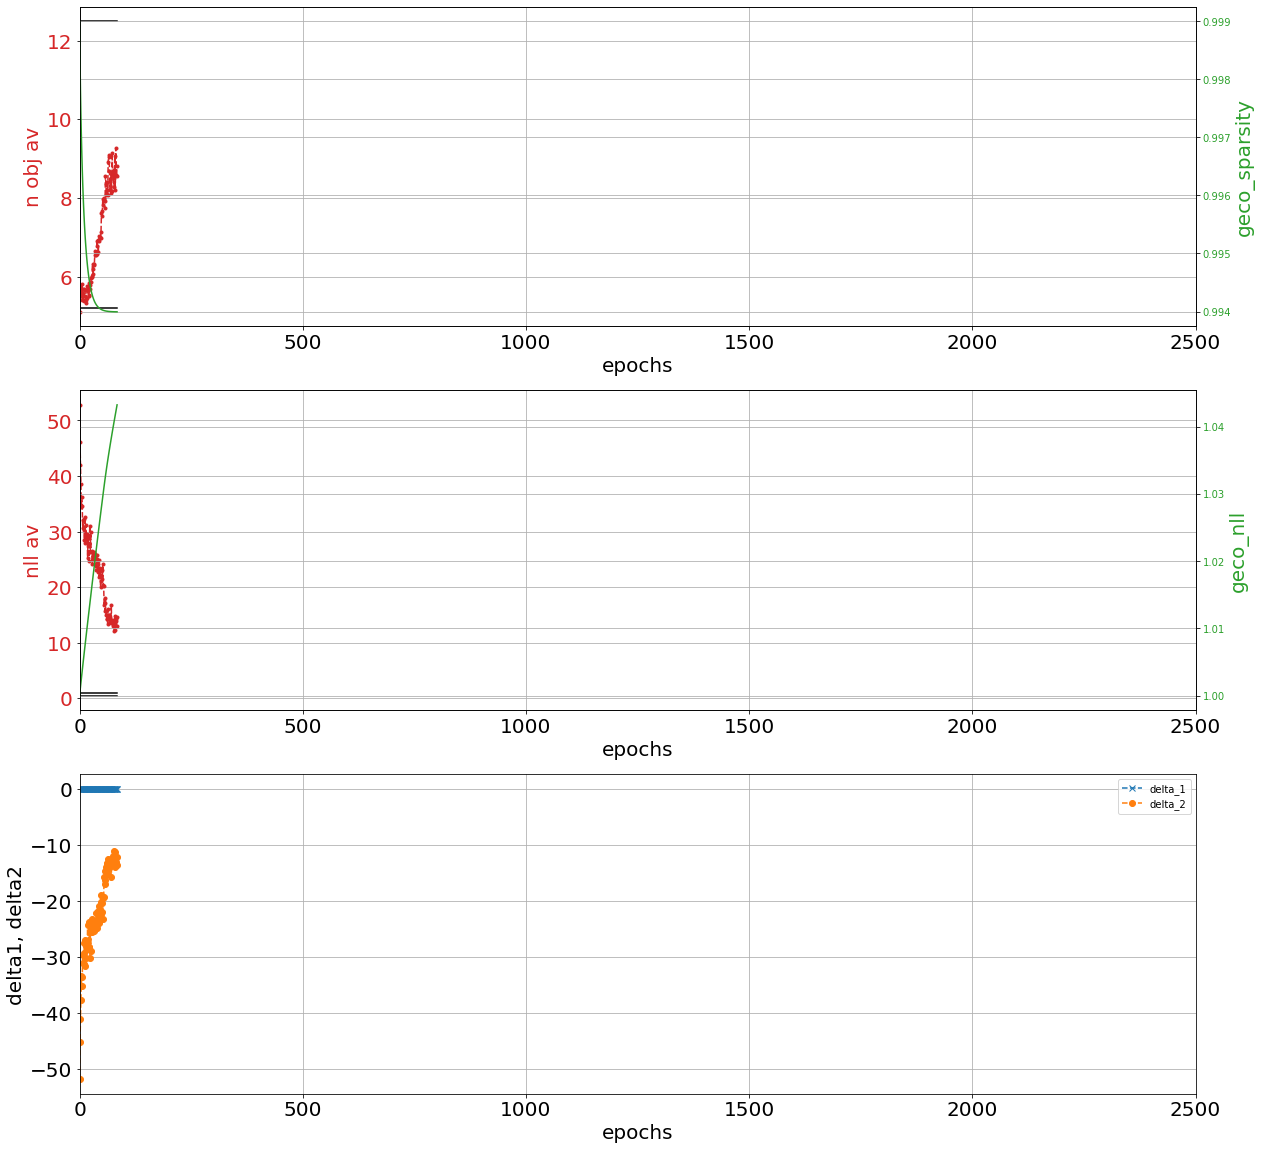

In [42]:
fontsize=20
labelsize=20
f = plt.figure(figsize=(20,20))
ax1 = f.add_subplot(311)
ax2 = f.add_subplot(312)
ax3 = f.add_subplot(313)
epoch_min, epoch_max = 0, 2500


#-----------------------------------

color = 'tab:red'
ax1.set_xlabel('epochs', fontsize=fontsize)
ax1.set_ylabel('n obj av', fontsize=fontsize, color=color)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax1.plot(history_dict["train_n_obj"], '.--', color=color, label="n_object")
ax1.set_xlim([epoch_min, epoch_max])


ymin=min(params["GECO"]["target_n_obj"])
ymax=max(params["GECO"]["target_n_obj"])
ax1.plot(ymin*np.ones(len(history_dict["train_n_obj"])), '-', color='black', label="y_min")
ax1.plot(ymax*np.ones(len(history_dict["train_n_obj"])), '-', color='black', label="y_max")
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()

ax1b = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax1b.set_xlabel('epochs', fontsize=fontsize)
ax1b.set_ylabel('geco_sparsity', color=color, fontsize=fontsize)
plt.plot(history_dict["train_geco_sparsity"],'-',label="geco_sparsity",color=color)
ax1b.tick_params(axis='y', labelcolor=color)
ax1b.grid()

##------------------------------------

color = 'tab:red'
ax2.set_xlabel('epochs', fontsize=fontsize)
ax2.set_ylabel('nll av', fontsize=fontsize, color=color)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)
ax2.plot(history_dict["train_nll"], '.--', color=color, label="nll av")
ax2.set_xlim([epoch_min, epoch_max])

ymin=min(params["GECO"]["target_nll"])
ymax=max(params["GECO"]["target_nll"])
ax2.plot(ymin*np.ones(len(history_dict["train_n_obj"])), '-', color='black', label="y_min")
ax2.plot(ymax*np.ones(len(history_dict["train_n_obj"])), '-', color='black', label="y_max")

ax2.tick_params(axis='y', labelcolor=color)
ax2.grid()

ax2b = ax2.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2b.set_xlabel('epochs', fontsize=fontsize)
ax2b.set_ylabel('geco_nll', fontsize=fontsize, color=color)
plt.plot(history_dict["train_geco_nll"],'-',label="geco_nll",color=color)
ax2b.tick_params(axis='y', labelcolor=color)
ax2b.grid()

#---------------------------------------
ax3.set_xlabel('epochs', fontsize=fontsize)
ax3.set_ylabel('delta1, delta2', fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=labelsize)
ax3.plot(history_dict["train_delta_1"], 'x--', label="delta_1")
ax3.plot(history_dict["train_delta_2"], 'o--', label="delta_2")
ax3.grid()
ax3.legend()
ax3.set_xlim([epoch_min, epoch_max])


##------------------------------------


fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig_file = os.path.join(dir_output, "geco.png")
plt.savefig(fig_file)

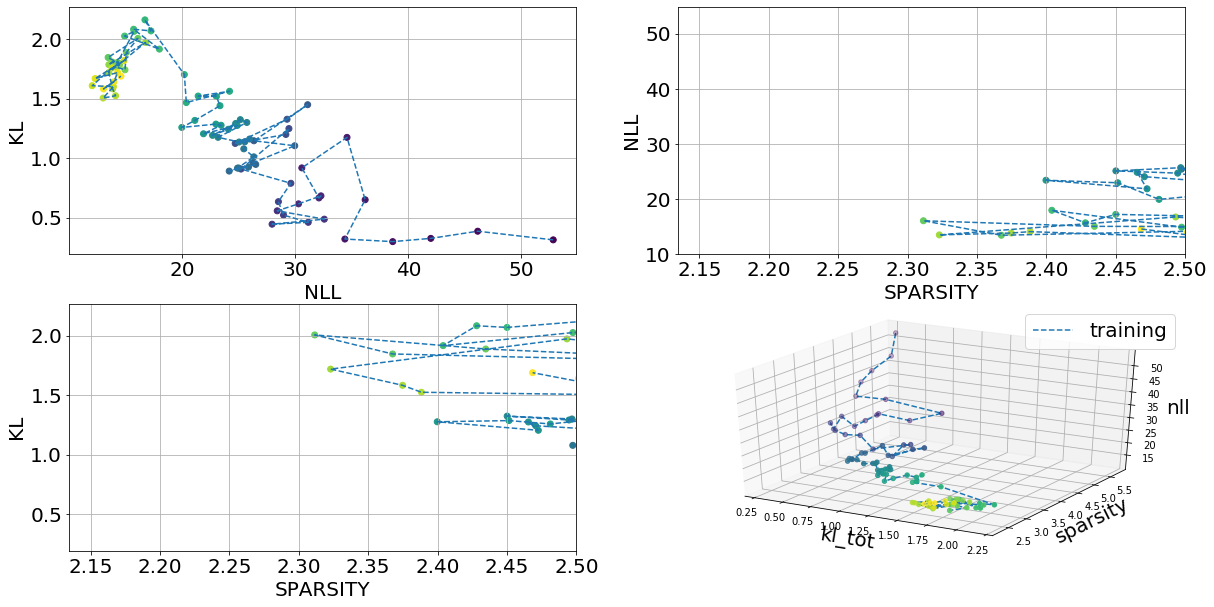

In [43]:
# Plot of KL vs evidence
fontsize=20
labelsize=20

epoch_min, epoch_max = 0, 2500
scale= 1
N = len(history_dict["train_nll"][epoch_min:epoch_max])
colors = np.arange(0.0,N,1.0)/N

f = plt.figure(figsize=(20,10))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224, projection='3d')

ax1.set_xlabel('NLL',fontsize=fontsize)
ax1.set_ylabel('KL',fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax1.scatter(history_dict["train_nll"][epoch_min:epoch_max], history_dict["train_kl_tot"][epoch_min:epoch_max],c=colors)
ax1.plot(history_dict["train_nll"][epoch_min:epoch_max], history_dict["train_kl_tot"][epoch_min:epoch_max], '--')
ax1.grid()
#ax1.set_xlim(xmax=2.5)

ax2.set_xlabel('SPARSITY',fontsize=fontsize)
ax2.set_ylabel('NLL',fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)
ax2.scatter(history_dict["train_sparsity"][epoch_min:epoch_max], history_dict["train_nll"][epoch_min:epoch_max], c=colors)
ax2.plot(history_dict["train_sparsity"][epoch_min:epoch_max], history_dict["train_nll"][epoch_min:epoch_max], '--')
ax2.grid()
ax2.set_xlim(xmax=2.5)

ax3.set_xlabel('SPARSITY',fontsize=fontsize)
ax3.set_ylabel('KL',fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=labelsize)
ax3.scatter(history_dict["train_sparsity"][epoch_min:epoch_max], history_dict["train_kl_tot"][epoch_min:epoch_max], c=colors)
ax3.plot(history_dict["train_sparsity"][epoch_min:epoch_max], history_dict["train_kl_tot"][epoch_min:epoch_max], '--')
ax3.grid()
ax3.set_xlim(xmax=2.5)


ax4.scatter(history_dict["train_kl_tot"][epoch_min:epoch_max],
         history_dict["train_sparsity"][epoch_min:epoch_max],
         history_dict["train_nll"][epoch_min:epoch_max], c=colors )

ax4.plot(history_dict["train_kl_tot"][epoch_min:epoch_max],
         history_dict["train_sparsity"][epoch_min:epoch_max],
         history_dict["train_nll"][epoch_min:epoch_max], '--', label='training')
ax4.set_xlabel('kl_tot', fontsize=fontsize)
ax4.set_ylabel('sparsity', fontsize=fontsize)
ax4.set_zlabel('nll', fontsize=fontsize)
ax4.legend(prop={'size':fontsize})

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig_file = os.path.join(dir_output, "nll_vs_kll_vs_sparsity.png")
plt.savefig(fig_file)

# Run one epoch in eval mode

In [44]:
#epoch=100
#load_model_optimizer(path=os.path.join(dir_output, "ckp_"+str(epoch)+".pkl"), model=vae)

vae.eval()
with torch.no_grad():
    test_metrics = process_one_epoch(model=vae, 
                                     dataloader=test_loader)
    print(test_metrics)

{'loss': 17.040383226335617, 'nll': 12.911669509887695, 'reg': 0.018150210179388525, 'kl_tot': 1.4646938705444337, 'kl_what': 0.5779435982704163, 'kl_mask': 0.15345139610767364, 'kl_where': 0.2948236222267151, 'kl_logit': 5086.8567734375, 'sparsity': 2.089787534713745, 'n_obj': 7.2059999961853025, 'geco_sparsity': 0.9939956578009373, 'geco_nll': 1.043978176619238, 'delta_1': 0.0, 'delta_2': -11.911669509887695, 'cost_fg_pixel_fraction': 0.008900475516915321, 'cost_overlap': 0.009249734245240688, 'accuracy': 0.0, 'wrong_examples': [1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1

# Check the error

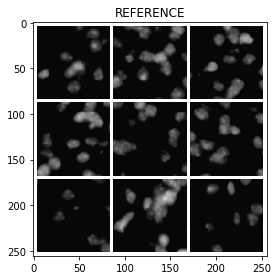

In [45]:
ref_img_pkl = os.path.join(dir_output, "reference.pkl")
tmp_list = [0, 1, 2,3,4,5,6,7,8,9]
#tmp_list = [255, 148, 291, 310, 2,3,4,5,6,7,8,9,10]
#tmp_list = [425, 411, 61, 194, 91, 384, 339, 54, 336]

reference_imgs, labels, index =test_loader.load(index=torch.tensor(tmp_list[:9]))
save_obj(reference_imgs, ref_img_pkl)

reference_imgs = load_obj(ref_img_pkl)
b = show_batch(reference_imgs[:],n_col=3,n_padding=4,title="REFERENCE")

ref_img_png = os.path.join(dir_output, "reference.png")
b.savefig(ref_img_png)
display(b)

In [46]:
vae.geco_dict

{'__comment': 'if active=false use ELBO, else use GECO with Log-Likelihood threshold = n_pixels * n_channel * threshold',
 'is_active': True,
 'factor_nll_range': [0.0, 1.0, 40.0],
 'factor_sparsity_range': [0.0, 1.0, 40.0],
 'target_n_obj': [5.2, 12.5],
 'target_nll': [0.5, 1.0]}

In [47]:
chosen=0
with torch.no_grad():
    print("")
    print("")
    print("--- eval mode ---")
    vae.eval()
    output_test = vae.forward(reference_imgs[:],
                              draw_image=True,
                              draw_bounding_box=True,
                              verbose=True)
    
    print("")
    print("")
    print("--- train mode ---")
    vae.train()
    output_train = vae.forward(reference_imgs[:],
                               draw_image=True,
                               draw_bounding_box=True,
                               verbose=True)



--- eval mode ---
constraint name -> fg_pixel_fraction
input value -> tensor([0.1723, 0.2533, 0.2314, 0.2349, 0.1704, 0.2105, 0.0907, 0.2177, 0.1252],
       device='cuda:0')
cost -> tensor([0.0000, 0.1134, 0.0395, 0.0487, 0.0000, 0.0044, 0.0000, 0.0126, 0.0000],
       device='cuda:0')
constraint name -> overlap
input value -> tensor([ 3.5956, 22.4761, 22.6022, 31.8290,  8.6297,  5.0905,  6.3086, 37.3082,
         9.1757], device='cuda:0')
cost -> tensor([0.0036, 0.0225, 0.0226, 0.0318, 0.0086, 0.0051, 0.0063, 0.0373, 0.0092],
       device='cuda:0')


--- train mode ---
constraint name -> fg_pixel_fraction
input value -> tensor([0.1730, 0.2349, 0.2326, 0.2095, 0.1741, 0.2069, 0.0925, 0.2261, 0.1300],
       device='cuda:0')
cost -> tensor([0.0000, 0.0487, 0.0426, 0.0036, 0.0000, 0.0019, 0.0000, 0.0272, 0.0000],
       device='cuda:0')
constraint name -> overlap
input value -> tensor([ 9.1561, 17.0719, 12.8516, 23.5058, 12.0001,  3.7537,  5.7737, 33.4647,
         8.2008], device='c

In [48]:
pmap_train = show_batch(output_train.inference.p_map, n_col=3,n_padding=4,title="Train Prob MAP")
pmap_test = show_batch(output_test.inference.p_map, n_col=3,n_padding=4,title="Test Prob MAP")

counts_train = torch.sum(output_train.inference.prob>0.5,dim=0).view(-1).cpu().numpy().tolist()
rec_train = show_batch(output_train.imgs[:],n_col=3,n_padding=4,title="# rec train "+str(counts_train))

counts_test = torch.sum(output_test.inference.prob>0.5,dim=0).view(-1).cpu().numpy().tolist()
rec_test = show_batch(output_test.imgs[:],n_col=3,n_padding=4,title="# rec test "+str(counts_test))

background = show_batch(output_train.inference.bg_mu,n_col=3,n_padding=4,title="BACKGROUND")
reference = show_batch(reference_imgs[:],n_col=3,n_padding=4,title="REFERENCE")

background.savefig(os.path.join(dir_output, "background.png"))
reference.savefig(os.path.join(dir_output, "reference.png"))
rec_test.savefig(os.path.join(dir_output, "rec_test.png"))
rec_train.savefig(os.path.join(dir_output, "rec_train.png"))
pmap_test.savefig(os.path.join(dir_output, "pmap_test.png"))
pmap_train.savefig(os.path.join(dir_output, "pmap_train.png"))

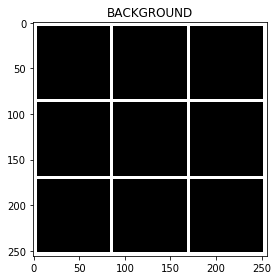

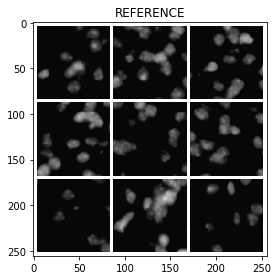

In [49]:
display(background, reference)

In [50]:
print(output_train.inference.p_map.sum(dim=(-1,-2,-3)).cpu())
print(output_test.inference.p_map.sum(dim=(-1,-2,-3)).cpu())

tensor([45.1067, 65.9901, 56.5008, 58.8977, 49.5989, 58.3339, 28.8039, 64.4569,
        37.6202])
tensor([47.3553, 69.5848, 62.0778, 68.5068, 51.0970, 62.6840, 28.5423, 74.7467,
        38.8084])


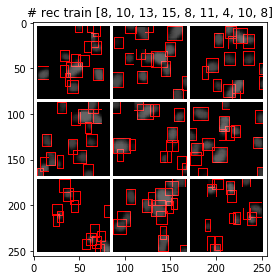

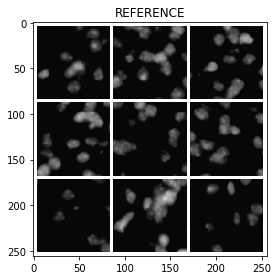

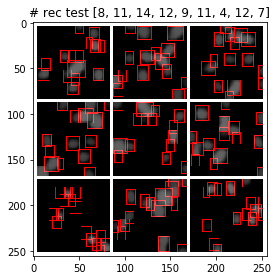

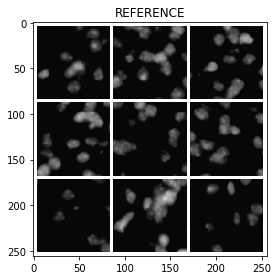

In [51]:
display(rec_train,reference)
display(rec_test,reference)

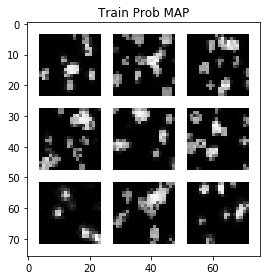

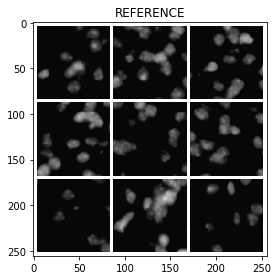

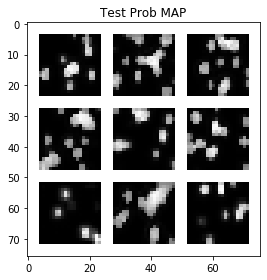

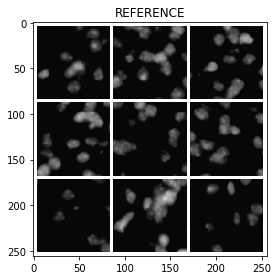

In [52]:
display(pmap_train,reference)
display(pmap_test,reference)

tensor([0.9877, 0.9640, 0.9521, 0.9385, 0.9383, 0.9300, 0.9192, 0.9082, 0.8984,
        0.8672], device='cuda:0')


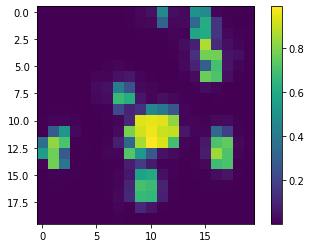

In [53]:
plt.imshow(output_train.inference.p_map[chosen,0].cpu().numpy())
_ = plt.colorbar()
print(torch.topk(output_train.inference.p_map[chosen,0].view(-1), k=10, largest=True, sorted=True)[0])

tensor([0.9877, 0.9643, 0.9636, 0.9522, 0.9408, 0.9300, 0.9193, 0.9087, 0.8982,
        0.8879], device='cuda:0')


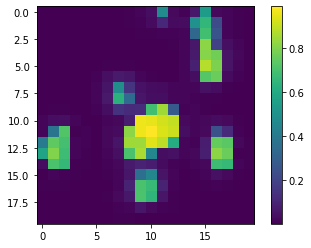

In [54]:
plt.imshow(output_test.inference.p_map[chosen,0].cpu().numpy())
_ = plt.colorbar()
print(torch.topk(output_test.inference.p_map[chosen,0].view(-1), k=10, largest=True, sorted=True)[0])

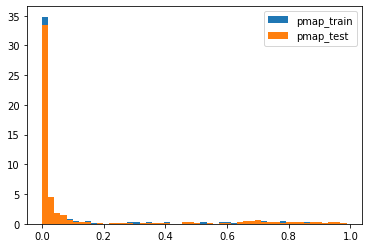

In [55]:
_ = plt.hist(output_train.inference.p_map[0,0].view(-1).cpu().numpy(), density=True, bins=50, label="pmap_train")
_ = plt.hist(output_test.inference.p_map[0,0].view(-1).cpu().numpy(), density=True, bins=50, label="pmap_test")
plt.legend()
plt.savefig(os.path.join(dir_output, "hist_pmap.png"))

# Visualize one chosen image in details

In [56]:
output = output_train
how_many_to_show=20
counts = torch.sum(output.inference.prob>0.5,dim=0).view(-1).cpu().numpy().tolist()
prob_tmp = np.round(output.inference.prob[:how_many_to_show,chosen].view(-1).cpu().numpy(),decimals=4)*10000
prob_title = (prob_tmp.astype(int)/10000).tolist()
print("counts ->",counts[chosen]," prob ->",prob_title)

counts -> 8  prob -> [0.9877, 0.8672, 0.8415, 0.8242, 0.7121, 0.7006, 0.6698, 0.5039, 0.465, 0.4596, 0.2698, 0.1489, 0.0981, 0.0825, 0.0793]


sum big_masks tensor(1.0000, device='cuda:0')
sum big_masks * big_imgs tensor(0.4140, device='cuda:0')
torch.Size([4, 1, 80, 80])


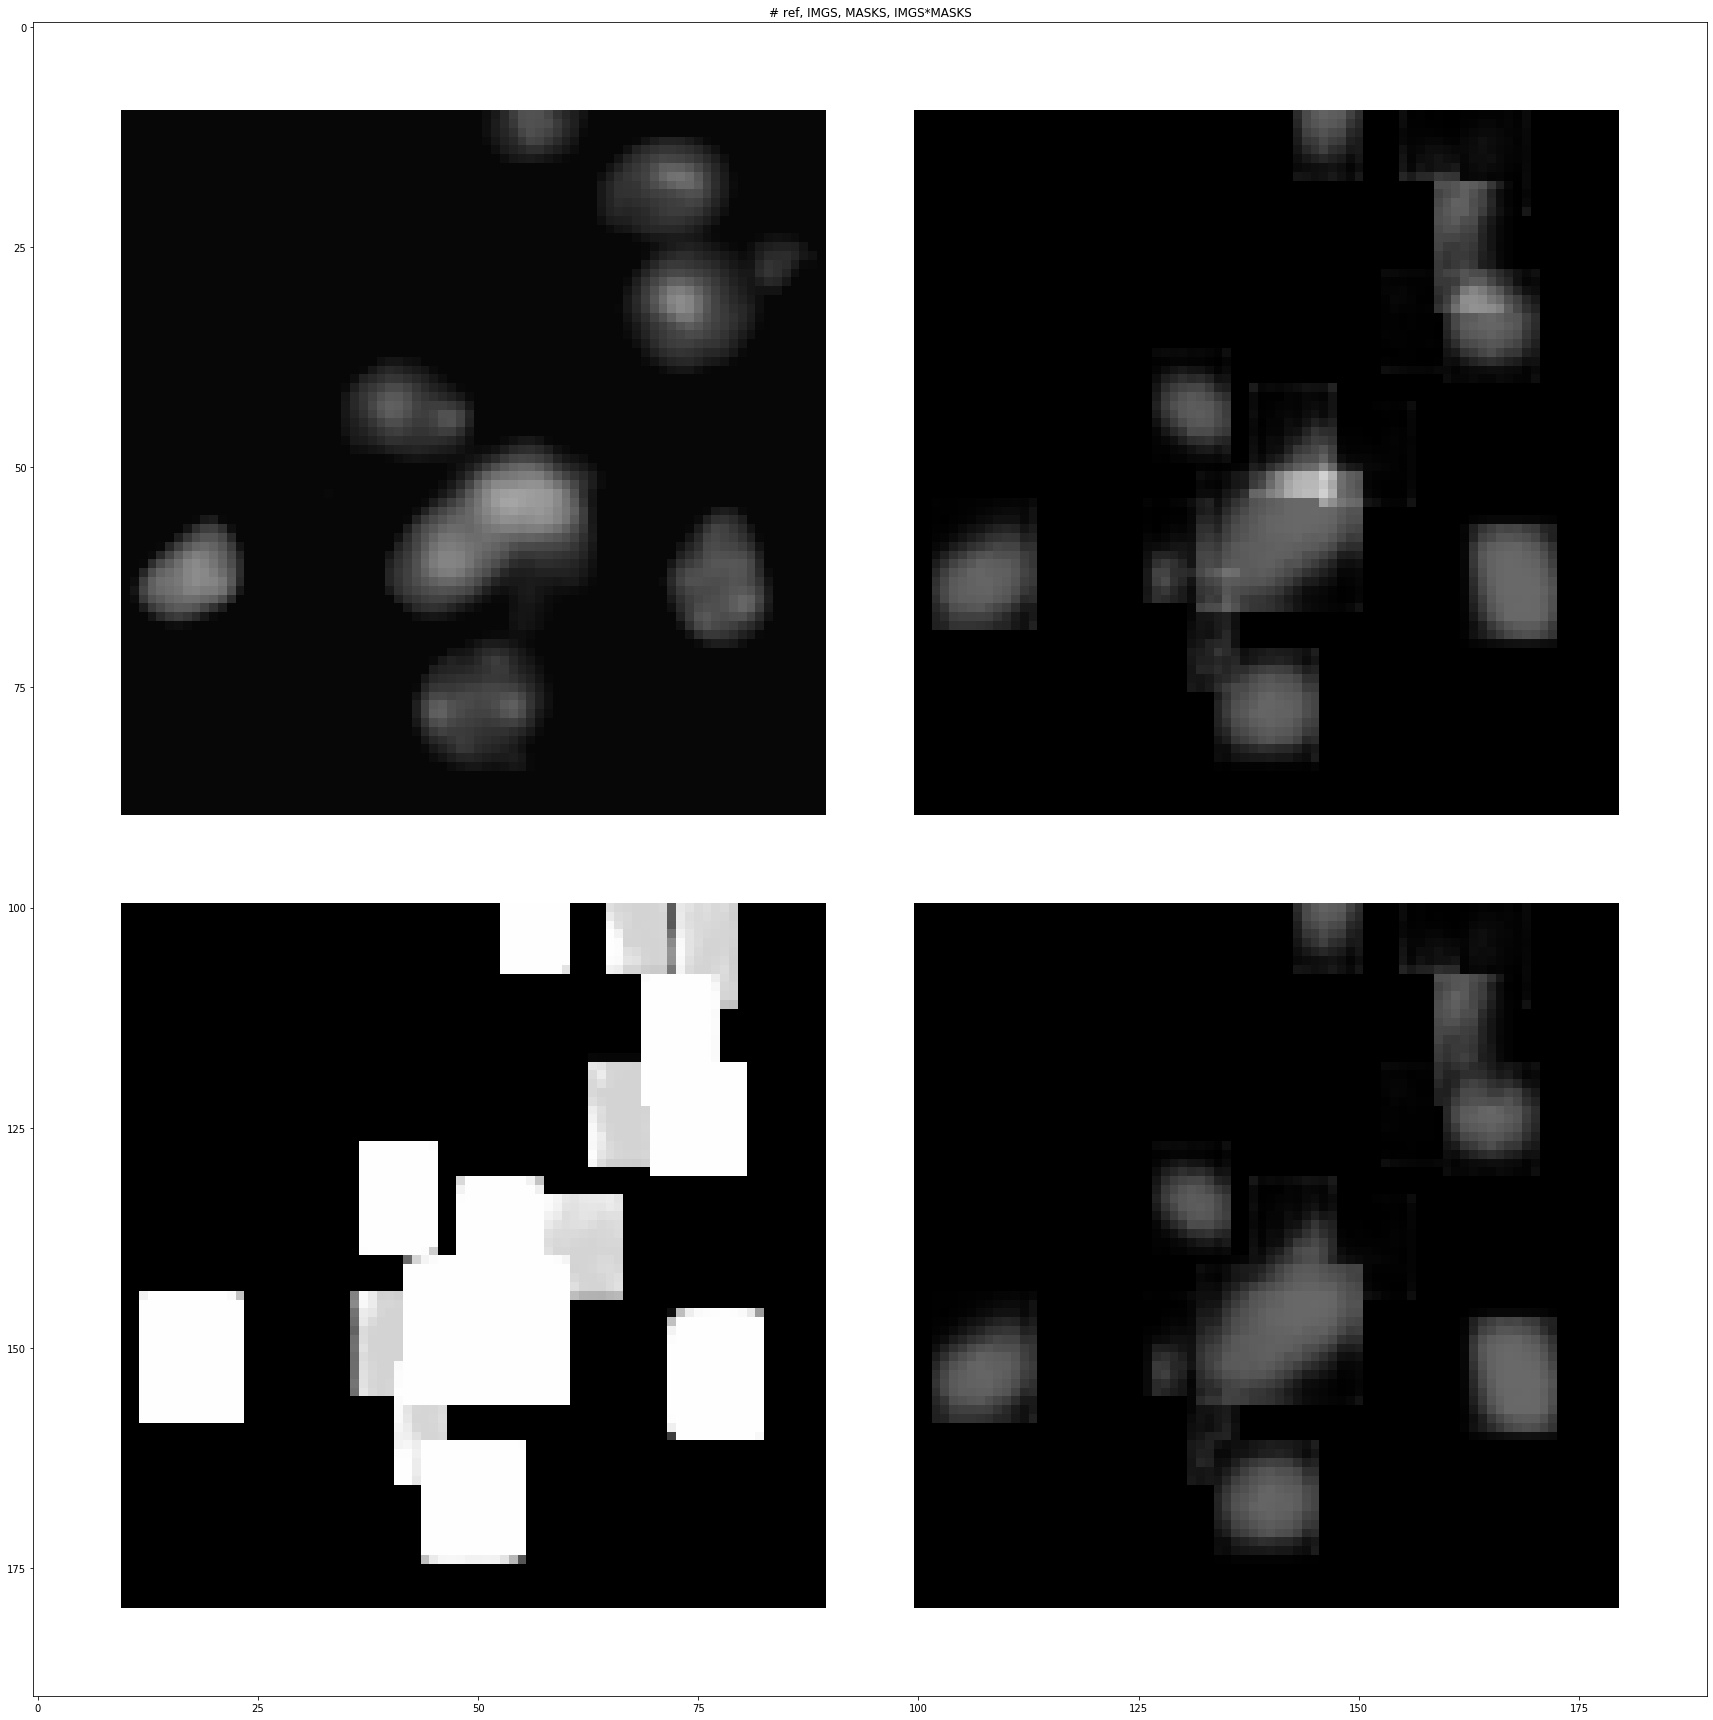

In [57]:
tmp1 = reference_imgs[chosen]
tmp2 = torch.sum(output.inference.big_img[:how_many_to_show,chosen],dim=0)
tmp3 = torch.sum(output.inference.big_mask[:how_many_to_show,chosen],dim=0)
mask_times_imgs = output.inference.big_mask * output.inference.big_img
tmp4 = torch.sum(mask_times_imgs[:how_many_to_show,chosen],dim=0)
print("sum big_masks", torch.max(tmp3))
print("sum big_masks * big_imgs", torch.max(tmp4))
combined = torch.stack((tmp1,tmp2,tmp3,tmp4),dim=0)
print(combined.shape)
b = show_batch(combined, n_col=2, title="# ref, IMGS, MASKS, IMGS*MASKS", figsize=(24,24))
b.savefig(os.path.join(dir_output, "ref_img_mask.png"))
display(b)

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


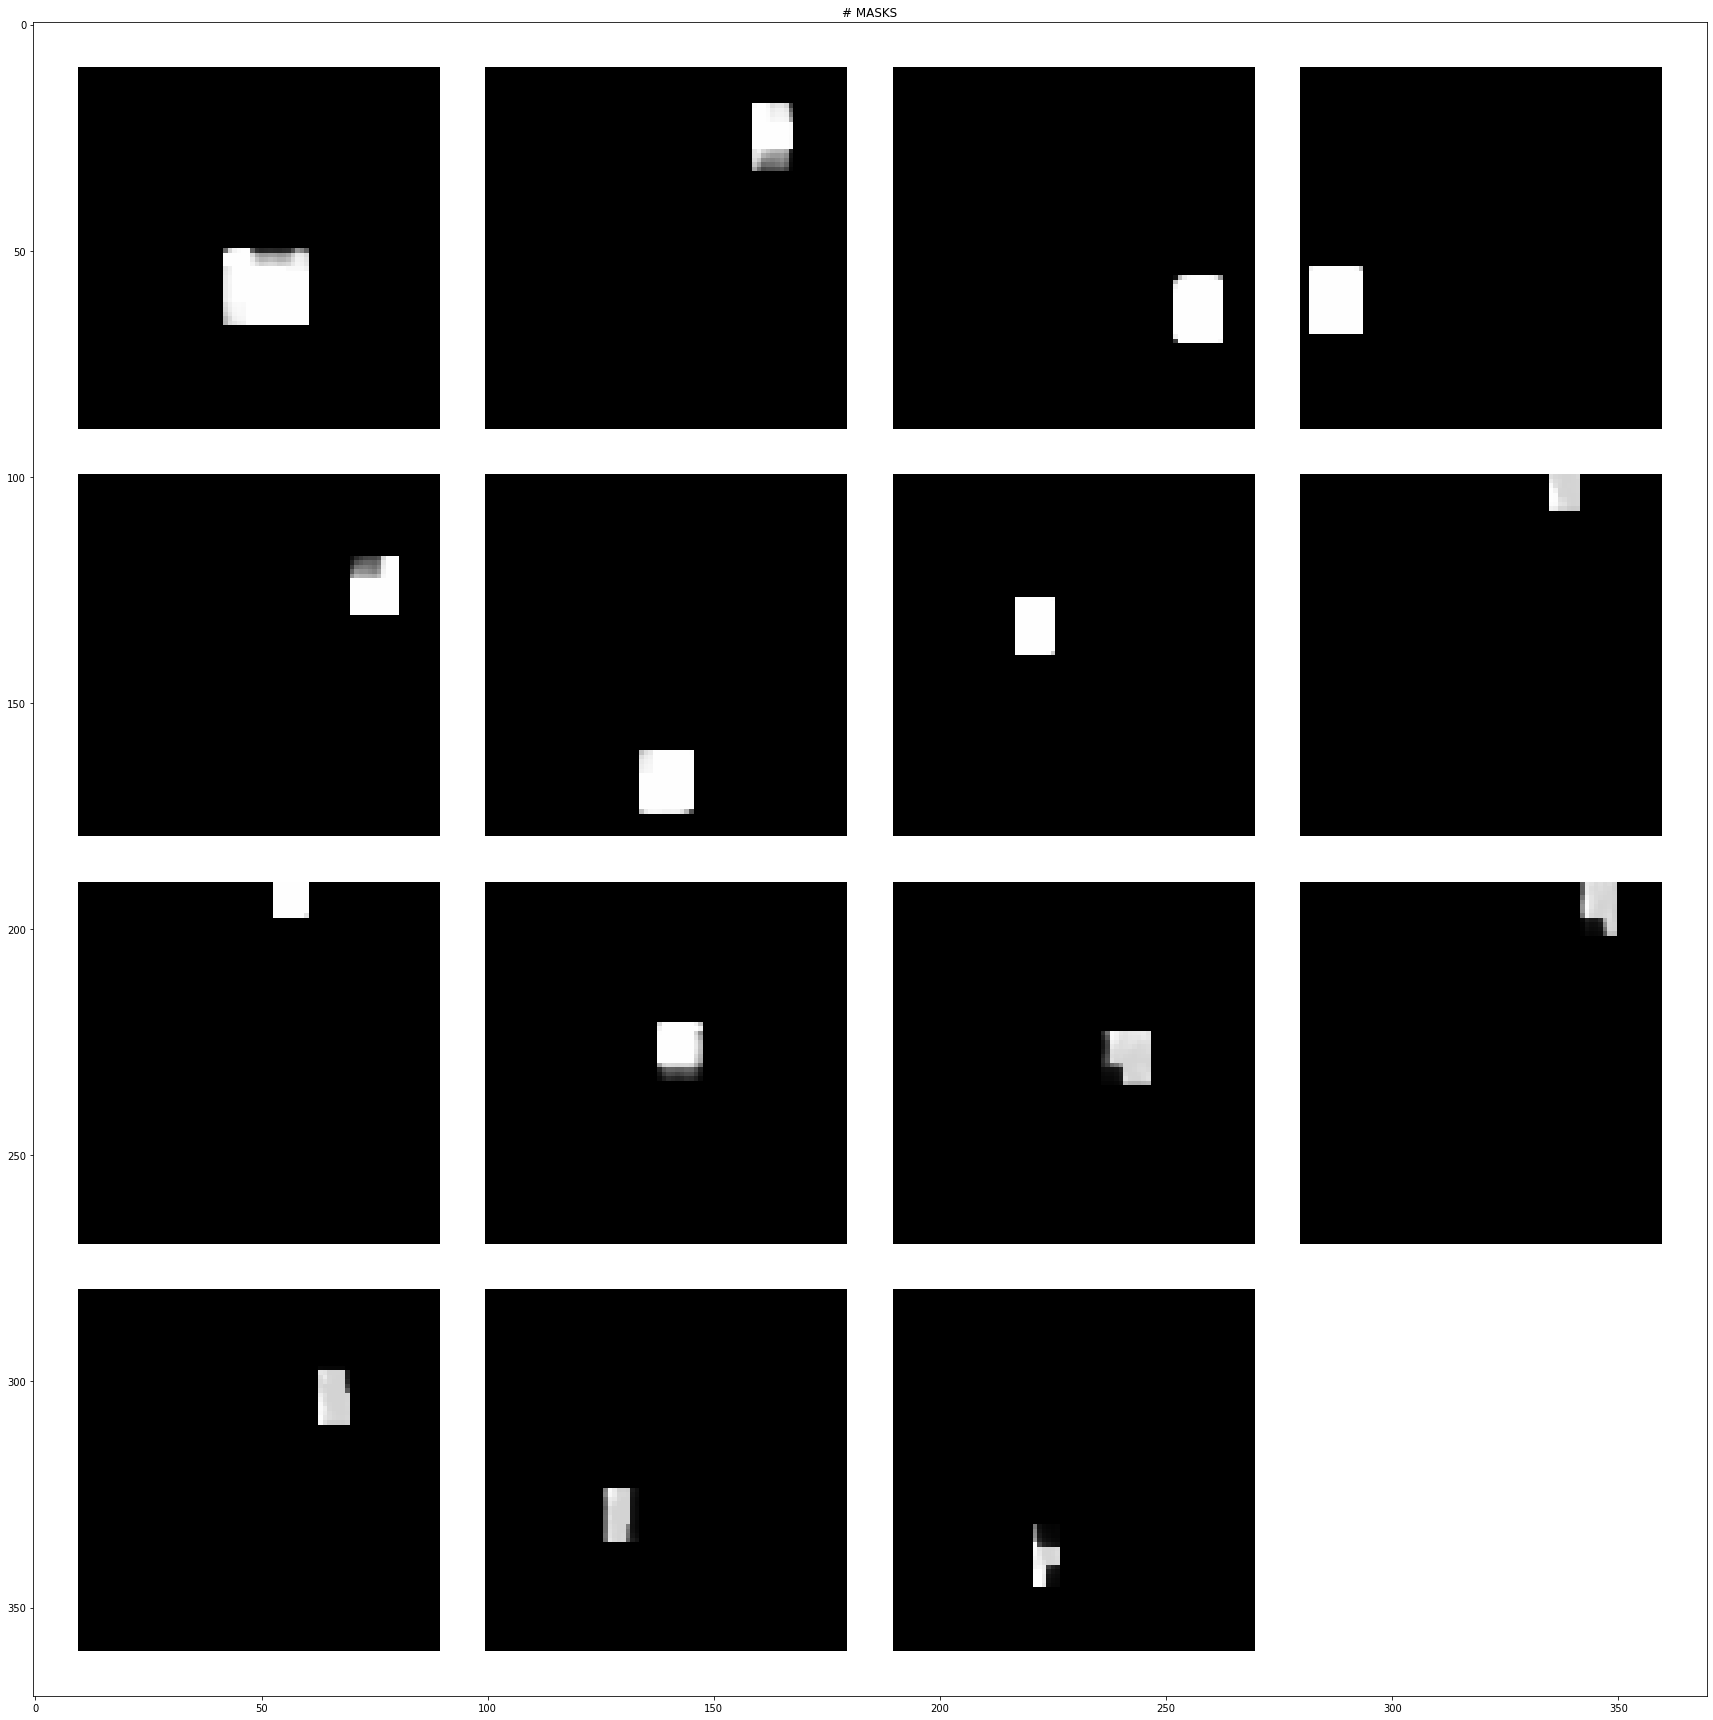

In [58]:
print(torch.min(output.inference.big_mask[:how_many_to_show,chosen]), torch.max(output.inference.big_mask[:how_many_to_show,chosen]))
show_batch(output.inference.big_mask[:how_many_to_show,chosen], n_col=4, title="# MASKS", figsize=(24,24))

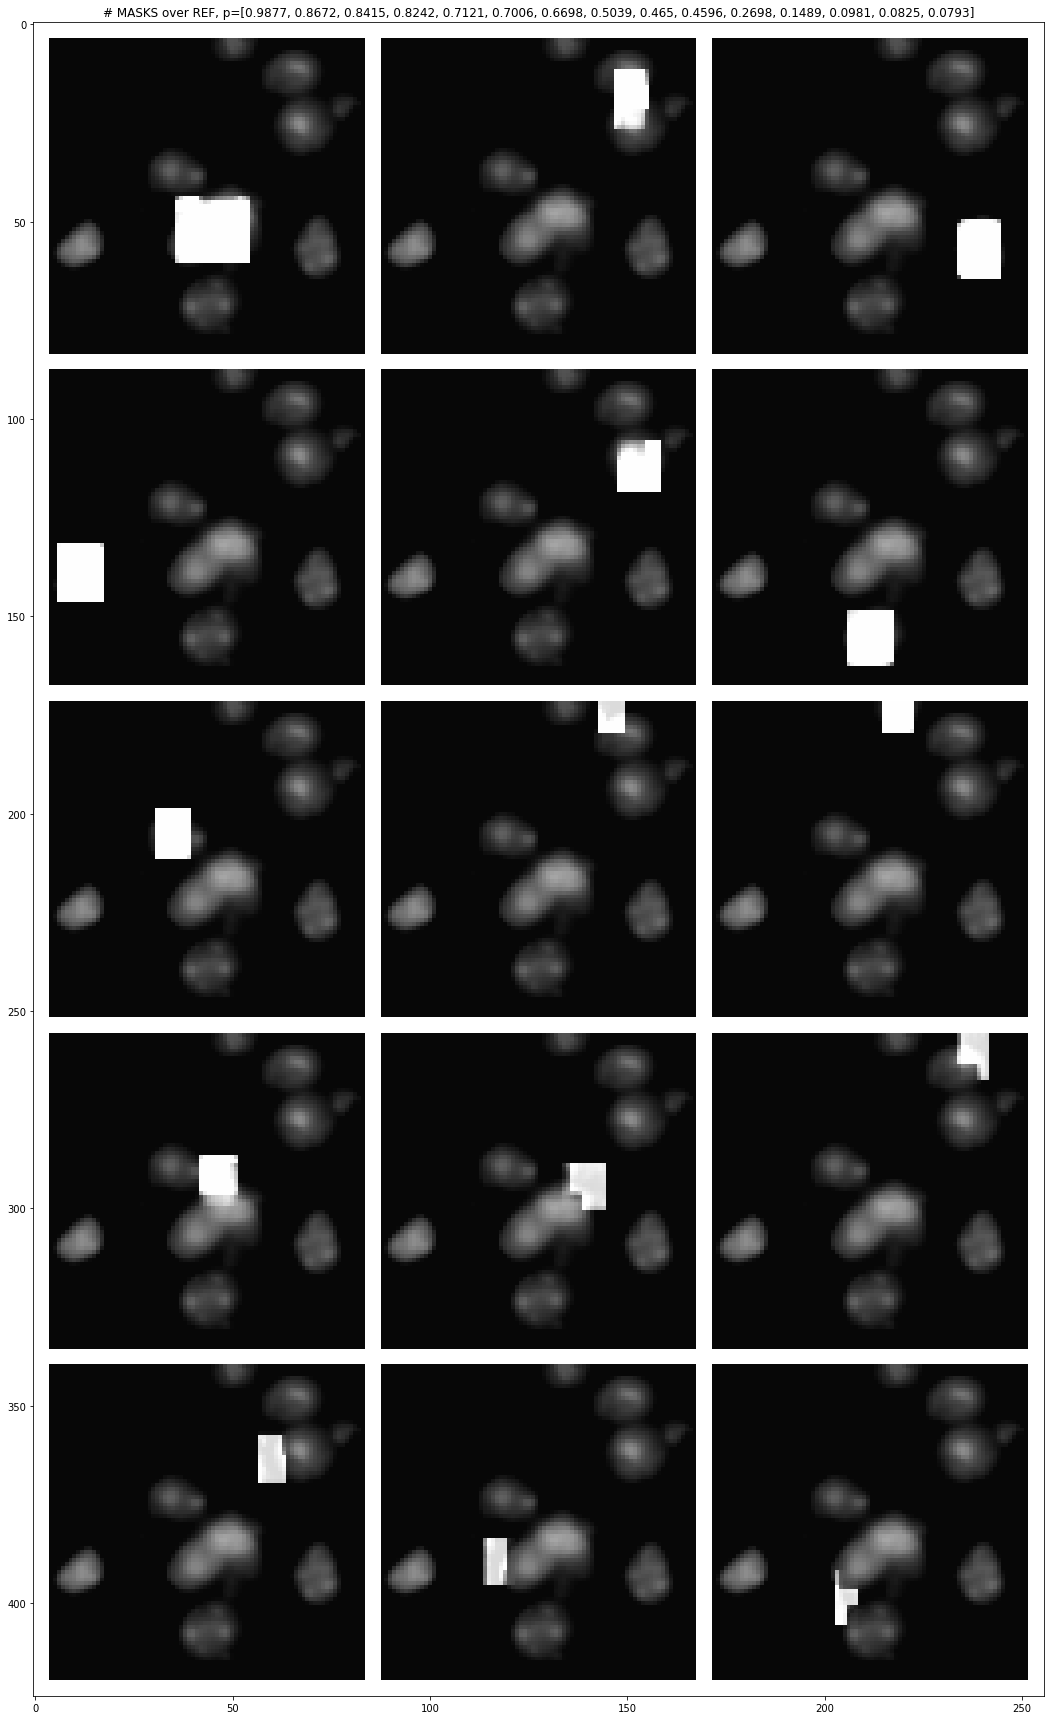

In [59]:
b = show_batch(reference_imgs[chosen]+output.inference.big_mask[:how_many_to_show,chosen], 
               n_col=3, n_padding=4,title="# MASKS over REF, p="+str(prob_title), figsize=(24,24))
b.savefig(os.path.join(dir_output, "mask_over_ref.png"))
display(b)

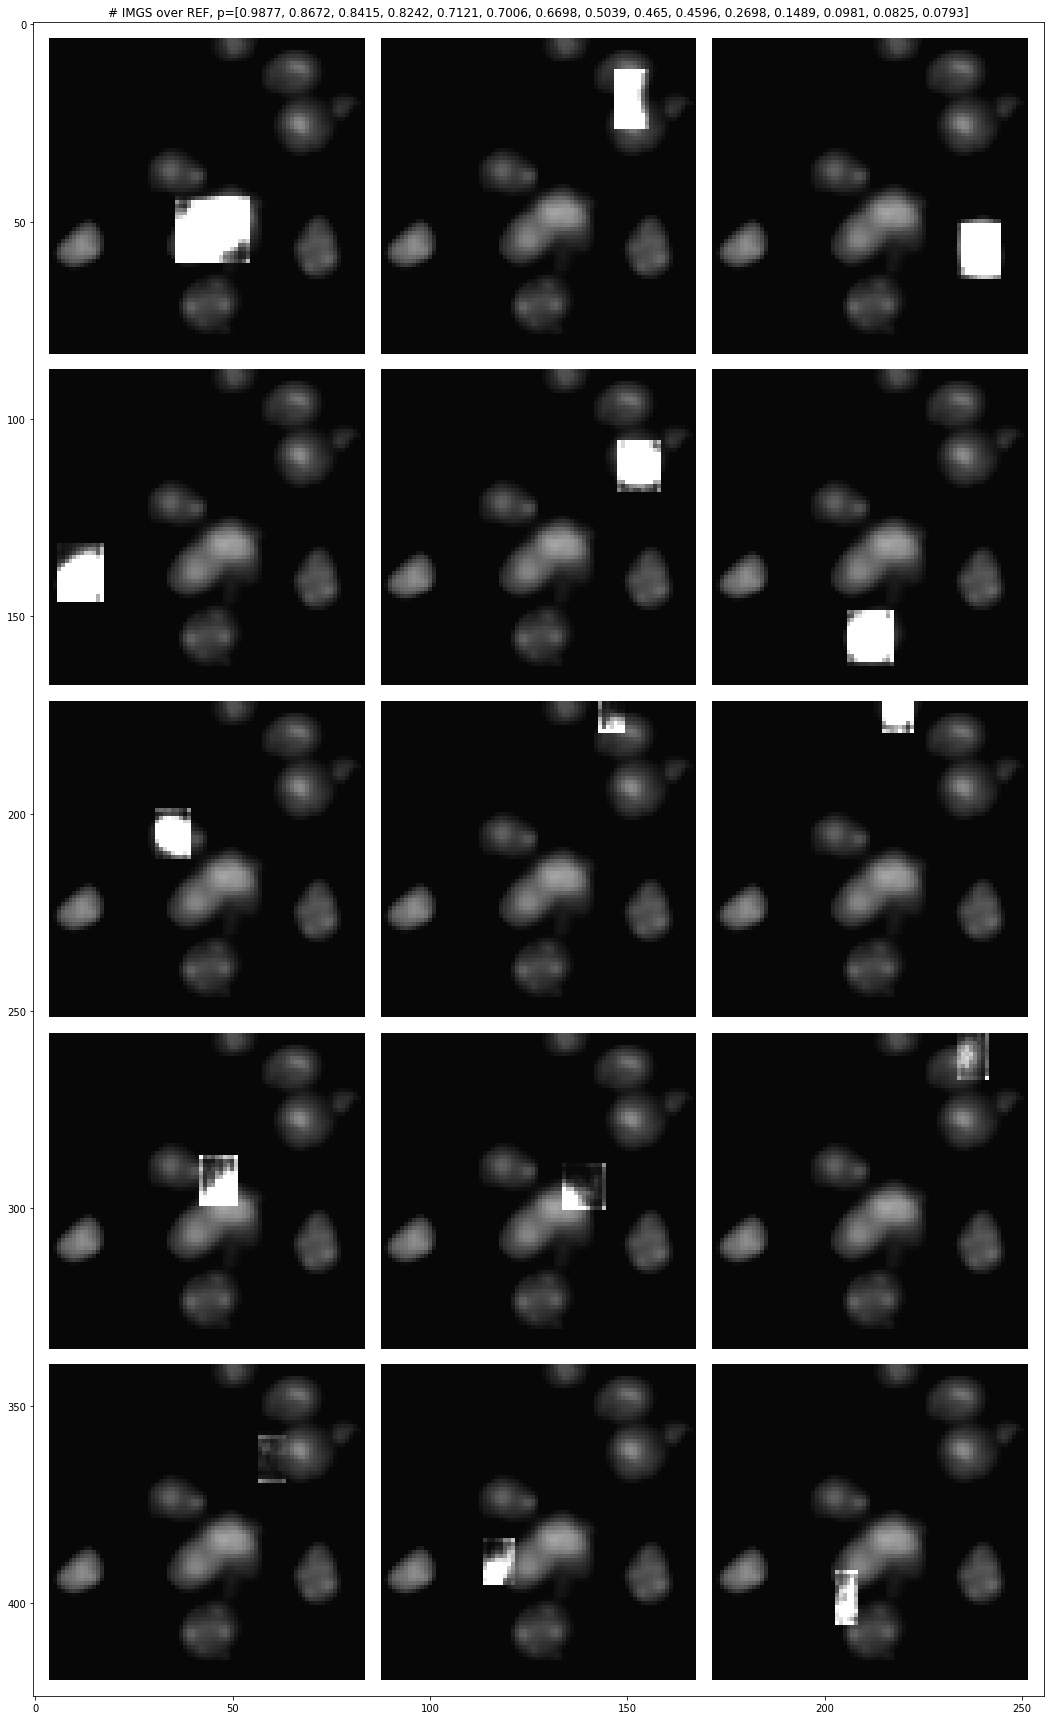

In [60]:
b = show_batch(reference_imgs[chosen]+10*output.inference.big_img[:how_many_to_show,chosen], 
               n_col=3, n_padding=4,title="# IMGS over REF, p="+str(prob_title), figsize=(24,24), normalize_range=(0,1))
b.savefig(os.path.join(dir_output, "imgs_over_ref.png"))
display(b)

In [61]:
output.inference.prob.shape

torch.Size([15, 9])

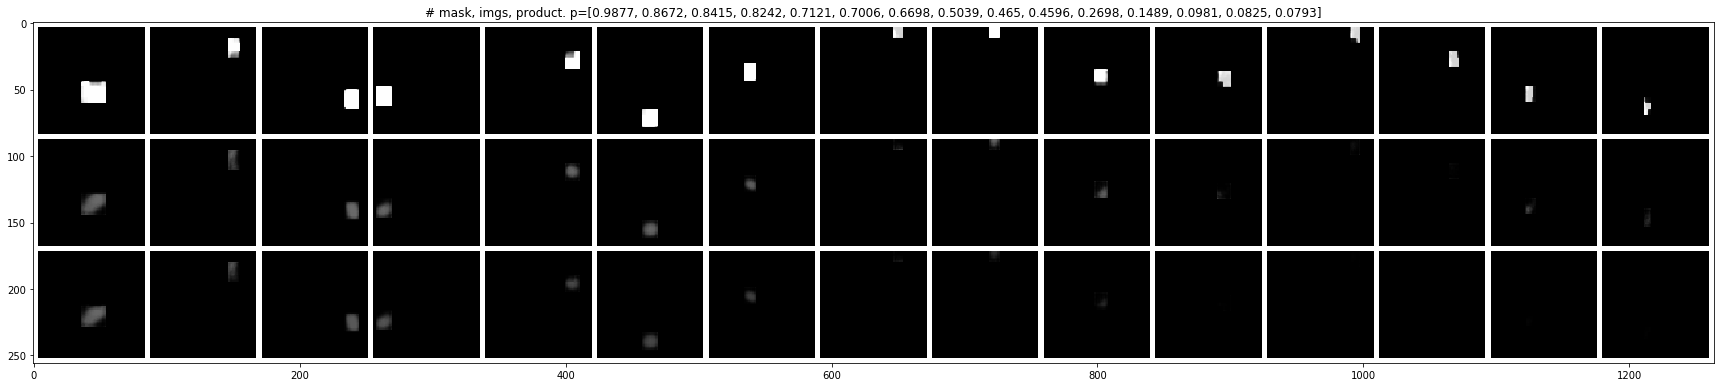

In [62]:
prob =  output.inference.prob[:,chosen, None, None, None]
b_mask = output.inference.big_mask[:,chosen]
b_img = output.inference.big_img[:,chosen]
b_combined = b_img * b_mask * prob
tmp = torch.cat((b_mask, b_img, b_combined), dim=0)
b = show_batch(tmp, n_col=tmp.shape[0]//3, n_padding=4, title="# mask, imgs, product. p="+str(prob_title), figsize=(24,24))
b.savefig(os.path.join(dir_output, "mask_imgs_product.png"))
display(b)

### Show the probability map

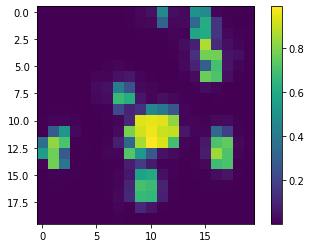

In [63]:
_ = plt.imshow(output.inference.p_map[chosen,0].cpu().numpy())
_ = plt.colorbar()
plt.savefig(os.path.join(dir_output, "pmap_chosen.png"))

# MAKE MOVIE

### Test

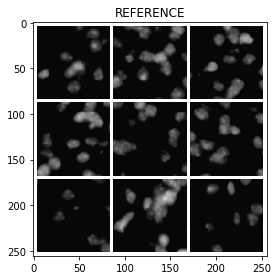

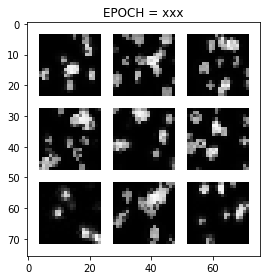

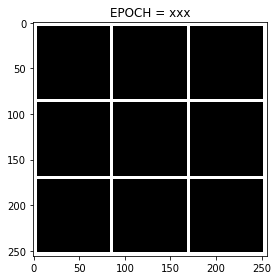

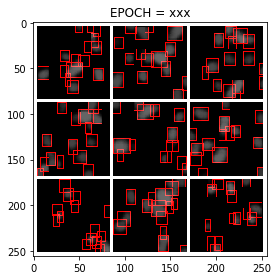

In [64]:
epoch="xxx"
a = show_batch(reference_imgs[:9],n_col=3,n_padding=4,title="REFERENCE")
b = show_batch(output.inference.p_map[:9],n_col=3,n_padding=4,title="EPOCH = "+str(epoch))
c = show_batch(output.inference.bg_mu[:9],n_col=3,n_padding=4,title="EPOCH = "+str(epoch))
d = show_batch(output.imgs[:9],n_col=3,n_padding=4,title="EPOCH = "+str(epoch))

display(a,b,c,d)

# actual loop

In [ ]:
for epoch in range(0,2000,20):
    if(epoch<10):
        label ="000"+str(epoch)
    elif(epoch<100):
        label = "00"+str(epoch)
    elif(epoch<1000):
        label = "0"+str(epoch)
    elif(epoch<10000):
        label = str(epoch)
    else:
        raise Exception
    

    try:
        load_model_optimizer(path=os.path.join(dir_output, "ckp_"+str(epoch)+".pkl"), model=vae)
        print("epoch, label, prob_cor_factor ->",epoch,label,vae.prob_corr_factor)
        vae.train()
        with torch.no_grad():
            output = vae.forward(reference_imgs,
                                 draw_image=True,
                                 draw_bounding_box=True,
                                 verbose=False)
        
        b=show_batch(output.imgs[:8],n_col=4,n_padding=4,title="EPOCH = "+str(epoch))
        b.savefig(os.path.join(dir_output, 'movie_rec_'+label+'.png'), bbox_inches='tight')
        
        b=show_batch(output.inference.p_map[:8],n_col=4,n_padding=4,title="EPOCH = "+str(epoch), normalize_range=None)
        b.savefig(os.path.join(dir_output, 'movie_map_'+label+'.png'), bbox_inches='tight') 
        
        b=show_batch(output.inference.bg_mu[:8],n_col=4,n_padding=4,title="EPOCH = "+str(epoch))
        b.savefig(os.path.join(dir_output, 'movie_bg_'+label+'.png'), bbox_inches='tight') 
    except:
        pass

epoch, label, prob_cor_factor -> 0 0000 0.5
epoch, label, prob_cor_factor -> 20 0020 0.5
epoch, label, prob_cor_factor -> 40 0040 0.5
epoch, label, prob_cor_factor -> 60 0060 0.5
epoch, label, prob_cor_factor -> 80 0080 0.5
epoch, label, prob_cor_factor -> 120 0120 0.4
epoch, label, prob_cor_factor -> 140 0140 0.3
epoch, label, prob_cor_factor -> 160 0160 0.2
epoch, label, prob_cor_factor -> 200 0200 0.0
epoch, label, prob_cor_factor -> 220 0220 0.0
epoch, label, prob_cor_factor -> 260 0260 0.0
epoch, label, prob_cor_factor -> 280 0280 0.0
epoch, label, prob_cor_factor -> 300 0300 0.0
epoch, label, prob_cor_factor -> 320 0320 0.0
epoch, label, prob_cor_factor -> 360 0360 0.0


## Make sorted list of image files so that I can create the movie

In [ ]:
dir_output

In [ ]:
rec_filenames = glob.glob(dir_output+"/movie_rec*.png")
map_filenames = glob.glob(dir_output+"/movie_map*.png")
bg_filenames = glob.glob(dir_output+"/movie_bg*.png")

rec_filenames.sort()
map_filenames.sort()
bg_filenames.sort()
print(rec_filenames)
print(map_filenames)
print(bg_filenames)

In [ ]:
def show_frame_rec(n):
    return Image(filename=rec_filenames[n])

def show_frame_map(n):
    return Image(filename=map_filenames[n])

def show_frame_bg(n):
    return display.Image(filename=bg_filenames[n])

def show_frame_all(n):
    try:
        a = Image(filename=bg_filenames[n])
        b = Image(filename=map_filenames[n])
        c = Image(filename=rec_filenames[n])
        return display(a,b,c)
    except IndexError:
        print("list index out of range")
        pass

In [ ]:
# make a gif file
movie_rec = os.path.join(dir_output, "movie_rec.gif")
movie_map = os.path.join(dir_output, "movie_map.gif")
movie_bg = os.path.join(dir_output, "movie_bg.gif")

frame_per_second = 2
im = mpy.ImageSequenceClip(rec_filenames, fps=frame_per_second)
im.write_gif(movie_rec, fps=frame_per_second)

im = mpy.ImageSequenceClip(map_filenames, fps=frame_per_second)
im.write_gif(movie_map, fps=frame_per_second)

im = mpy.ImageSequenceClip(bg_filenames, fps=frame_per_second)
im.write_gif(movie_bg, fps=frame_per_second)

### Show the movies

In [ ]:
show_batch(reference_imgs[:8],n_col=4,n_padding=4,title="REFERENCE")

In [ ]:
HTML("<img src="+movie_rec+"></img>")

In [ ]:
HTML("<img src="+movie_map+"></img>")

In [ ]:
show_batch(reference_imgs[:8],n_col=4,n_padding=4,title="REFERENCE")

In [ ]:
HTML("<img src="+movie_bg+"></img>")

### Look at few frames

In [ ]:
show_frame_all(0)

In [ ]:
show_frame_all(1)

In [ ]:
show_batch(reference_imgs[:8],n_col=4,n_padding=4,title="REFERENCE")

In [ ]:
show_frame_all(10)

In [ ]:
show_frame_all(11)

In [ ]:
show_frame_all(15)

In [ ]:
show_frame_all(20)

In [ ]:
show_frame_all(21)

In [ ]:
show_frame_all(22)

In [ ]:
show_frame_all(23)

In [ ]:
show_frame_all(24)

In [ ]:
show_batch(reference_imgs[:8],n_col=4,n_padding=4,title="REFERENCE")